# Ordinary Differential Equation Solver "Odie:" Quickstart

## Authors: Gabriel M Steward

### May 2023

### </list_source_code> NRPy+ Source Code for this module:
[cmdline_helper.py](/edit/cmdline_helper.py) (Multiplatform command line interface) 

[outputC.py](/edit/outputC.py) (NRPy+ code for packaging and compiling C)

https://github.com/zachetienne/nrpytutorial/blob/master/Tutorial-Start_to_Finish-Finite_Difference_Playground.ipynb (template for using outputC.py)

https://github.com/zachetienne/nrpytutorial/blob/master/Tutorial-Solving_the_Scalar_Wave_Equation_with_NumPy.ipynb (basic Python plotting code)

(All of this will need to be adjusted when properly inside the actual nrpytutorial repository). 

[Examples](NRPy+_OdieGM_Examples.ipynb)

[Quickstart](NRPy+_OdieGM_Quickstart.ipynb)

[Full Documentation](NRPy+_OdieGM_Full_Documentation.ipynb)

[Code Regeneration](NRPy+_OdieGM_Code_Regeneration.ipynb)

## Introduction:
Welcome to the Ordinary Differential Equation Solver Quickstart notebook, wherin we will both showcase a program that solves Ordinary Differential Equations and instruct users on how to use it. This notebook is designed as a tutorial to get users right into using the program, as well as providing a playground for users to not only play around, but also code custom implementations easily should it be desired. 

This Ordinary Differential Equation Solver, affectionately known as "Odie," takes a system of Ordinary Differential Equations (ODEs) with initial boundary conditions and solves it numerically. There are many ways to implement the code, but the primary method shown here produces a text file with the previously unknown functions' values at various sequential points. 

More detailed information about what Odie is and how it operates can be found in the [Full Documentation](NRPy+_OdieGM_Full_Documentation.ipynb) notebook. There are other notebooks as well; the [Examples](NRPy+_OdieGM_Examples.ipynb) notebook contains two examples of how to use Odie to solve problems, and the [Code Regeneration](NRPy+_OdieGM_Code_Regeneration.ipynb) notebook can produce Odie's C-files in case they are lost are changed in a way that can't be reversed. 

The code can be run entirely in either this jupyter notebook or as C-files. The C-file version has five files, four of which are the code itself, and the fifth is an example implementation that should be able to handle most systems of ODEs given to it. This jupyter notebook recreates the code in the C-files in full, however, it does not split it up into five files but rather creates one large file to be run all at once. Each section is still clearly labeled, and the various tutorial sections will make it clear what goes where. 

More advanced parts of Odie's operation are not included in this Notebook, anything that exists "under the hood" is only gone over in the [Full Documentation](NRPy+_OdieGM_Full_Documentation.ipynb) notebook; most users won't need to know it anyway. 

### Citations:

<a id='1'></a>
[1] https://stackoverflow.com/questions/51052314/access-variables-in-struct-from-void-pointer (how to deal with the very annoying void pointers)

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

1. [Step 1:](#S1) Background: The Problem Statement

3. [Step 2:](#S2) The Code

    1. [Step 2a:](#S2a) Python Preliminary Code

    4. [Step 2b:](#S2b) Background C Code

    6. [Step 2c:](#S2c) User-Defined Functions
    
    6. [Step 2d:](#S2d) The Provided Main Function

7. [Step 3:](#S3) User-Defined Problem Section

    1. [Step 3a:](#S3a) Customization

    4. [Step 3b:](#S3b) Code Compilation

    6. [Step 3c:](#S3c) Results
    
    6. [Step 3d:](#S3d) Analysis

9. [Step 4:](#S4) Output this notebook to $\LaTeX$-formatted PDF file

<a id='S1'></a>

# Step 1: Background: The Problem Statement \[Back to [top](#toc)\]
$$\label{S1}$$

#### In order to solve a problem, one must first know the problem exists.

Before we get into the code and instruct potential users on how to use it, we first need to specify exactly what sorts of problems it can solve. 

Odie seeks to take a system of Ordinary Differential Equations (ODEs) and solve it. To be clear, an ODE is an equation relating a function and its derivatives together, with the requirement that all derivatives be taken with respect to a single variable. If multiple variable derivatives are involved, it becoems a Partial Differential Equation. While the program only solves systems of first-order ODEs, every higher-order ODE can be split up into a system of first-order ODEs, thus the program can solve any order ODE so long as the user splits it up into a system first. 

Mathematically, our program can solve equations of the form

$$ \frac{dy(x)}{dx} = f(x,y(x)) ; \text{ given } y(a)=b$$

where a system would be written as

$$ \frac{d\vec y(x)}{dx} = \vec f(x,\vec y(x)) ; \text{ given } \vec y(a)=\vec b$$

where each $\vec f$ component is some algebraic function. Here, each vector quantity contains a number of components equal to the number of equations in the system. If there are four components in $\vec f$, then there are four in $\vec y$ and $\vec b$. 

A solution to the system is to find what the functions in $\vec y$ actually are. The given $\vec y(a)=\vec b$ are the boundary conditions for the problem. There needs to be one of these for each component in $\vec y$. For this solver, we start at the point $a$ and increase it over time, treating $a$ as the start of an "initial condition." If the user wanted to evolve backward from some point, the system would simply have to be flipped.  

The program will restrict itself to Runge-Kutta and Adams-Bashforth type solution methods, which take an initial condition and evolve it forward in "time" with various relational methods. The specifics of these methods can be found elsewhere ([here](https://nbviewer.org/github/zachetienne/nrpytutorial/blob/master/Tutorial-RK_Butcher_Table_Dictionary.ipynb)) (NOTE: the notebook may not be updated to include Adaptive Runge-Kutta and Adams-Bashforth methods). 

The basic idea is that one value is used to calculate another value forward in "time," and this new value can be used to find the next one, and so on and so forth. Since we start with an initial condition, we can always use such methods. 

Adams-Bashforth methods require multiple points in order to evaluate forward one step, but this can be solved by either using a Runge-Kutta method for the first few steps, or starting from the first order Adams-Bashforth method and increasing it over time. Both options are supported by Odie. 

<a id='S2'></a>

# Step 2: The Code \[Back to [top](#toc)\]
$$\label{S2}$$

#### Odie is our friend, but do we understand our friend?

Before looking at the code itself, lets first discuss how it operates. In the C-code, there are five different files: `nrpy_odiegm.h`, `nrpy_odiegm_proto.c`, `nrpy_odiegm_funcs.c`, `nrpy_odiegm_user_methods.c`, and `nrpy_odiegm_main.c`.

`nrpy_odiegm.h` and `nrpy_odiegm_proto.c` serve very similar purposes. `nrpy_odiegm.h` contians the definitions for all the struct "objects" used by Odie. It also contains all the butcher tables that come pre-installed with the program: 15 standard Runge-Kutta methods, 6 inherently adaptive Runge-Kutta methods, and a table that stores all 19 Adams-Bashforth methods in one. Details about all these methods, their orders, and validaitions can be found elsewhere in [NRPy+ docmentation](https://nbviewer.org/github/zachetienne/nrpytutorial/blob/master/Tutorial-RK_Butcher_Table_Dictionary.ipynb) (NOTE: link will need to be changed once in the nrpytutorial repository). `nrpy_odiegm_proto.c` just contains function prototypes, separated from `nrpy_odiegm.h` for organization purposes. 

`nrpy_odiegm_funcs.c` contains the functions prototyped in `nrpy_odiegm_proto.c`. The functions in here are irrelevant as while they contain the bulk of Odie's code, they also generally aren't necessary for a new user to look into. 

The three files above are expected to never be touched by the user, always running in the background. This is not the case for `nrpy_odiegm_user_methods.c`, which contains the various functions the user is expected to define, including the system of ODEs. In theory, it is possible to run Odie without `nrpy_odiegm_user_method.cs`, but that will put a lot more weight on the user to come up with the exactly correct format of functions. This template makes things much simpler. It does not depend on anything in the previous three files. 

The last file, `nrpy_odiegm_main.c`, is not actually part of the Odie program, but an example file provided that can handle almost any differential equation passed to it, and it is prepared in such a way that it can even evaluate basic hybrid methods. It is not the most efficient possible program, as it performs a lot of checks to tell what it's supposed to be doing at any given time, so if efficeincy is the name of the game the user should define a custom main. 

We will go through each of these files and build them up in turn, though code the user doesn't need to know about will be compiled without any explanation. It is not recommended to try and read the giant walls of red text inside the cells that define the code--the explanations outside the cells should be sufficient for use. 

<a id='S2a'></a>

## Step 2a: Python Preliminary Code \[Back to [top](#toc)\]
$$\label{S2a}$$

#### So, you want to run C-code in a ipykernel notebook? 

In order to run Odie, which is a C-code, from within this Python-based jupyter notebook, we will need to rely on NRPy+'s C-code generation libraries. This notebook, while it is a tutorial, is not concerned with explaining the ins and outs of how to do this; that can be found in the various [nrpytutorial notebooks](https://github.com/zachetienne/nrpytutorial). (NOTE: link will need to be changed when this notebook is in the nrpytutorial repository). 

In [1]:
import outputC as outC       # NRPy+: Core C code output module.
import cmdline_helper as cmd # NRPy+: Multi-platform Python command-line interface
import os                    # Python: Miscellaneous operating system interfaces
import shutil                # Python: High level file operations

# https://github.com/zachetienne/nrpytutorial/blob/master/Tutorial-Start_to_Finish-Finite_Difference_Playground.ipynb

# Create a C code output directory
# First, name it.
Ccodesrootdir = os.path.join("nrpy_odiegm_notebook_codes/")
# Remove any previously existing files there.
shutil.rmtree(Ccodesrootdir,ignore_errors=True)
# Create the fresh directory. 
cmd.mkdir(Ccodesrootdir)

<a id='S2b'></a>

## Step 2b: Background C Code \[Back to [top](#toc)\]
$$\label{S2b}$$

#### Taking it from the top.

The following cells construct `nrpy_odiegm.h`, `nrpy_odiegm_proto.c`, and `nrpy_odiegm_funcs.c`. The specifics are unimportant, the cells just need to be run. 

In [2]:
nrpy_odiegm_h = r"""  

// #include <stdio.h>
// #include <stdlib.h>
// #include <math.h>
// #include <stdbool.h>

// Note: math.h requries the "-lm" arg be added at the END of tasks.json's arguments.
// https://askubuntu.com/questions/332884/how-to-compile-a-c-program-that-uses-math-h

// ODE Solver "Odie"
// By G. M. Steward
// The main goal of this project is to solve Ordinary Differential Equation Systems
// in complete generality.
// This tenth version seeks to make this code functional as a drop-in replacement for GSL's solver. 

// Heavily influenced by Numerical Mathematics and Computing 6E by Cheney and Kincaid
// and GSL's ODE Solver, especially the method for adaptive time step and high-level funcitonality. 

// https://git.ligo.org/lscsoft/lalsuite/-/blob/master/lalsimulation/lib/LALSimIMRTEOBResumS.c
// Lalsuite section for what parts of GSL this was designed to replace. 

// This is the header file for Odie. 
// It contains the structure definitions. 
// The structs are defined below largely in accordance with GSL definitions. 
// However, unecessary variables were removed, and many new ones were added. 
// Butcher tables can be found at the bottom of this file. 
// Function prototypes can be found in nrpy_odiegm_proto.c


typedef struct {
    int (*function) (double x, double y[], double dydx[], void *params);
    // The function passed to this struct contains the definitions of the differnetial equations. 
    // int (*jacobian) (double t, const double y[], double *dfdy, double dfdt[], void *params); 
    // The Jacobian was a holdover from GSL, it will not be used in this program.
    int (*true_function) (double x, double y[]);
    // INSTEAD we will use the Jacobian's slot slot to allow passing of a true value! 
    // Naturally, this is only used if desired.
    size_t dimension; //For storing how big our system of equations is. 
    // Just pass it an int, usually. 
    void *params; // For storing extra constants needed to evaluate the functions. 
    // params->dimension stores how many there are. 
    // Struct definition can be found in nrpy_odiegm_user_methods.c
} nrpy_odiegm_system;


typedef struct {
    // Unlike with the system struct above, this step_type struct does not need
    // to match GSL's form explicitly, it just needs to define the method.
    int rows; 
    int columns; // Size of table for used method.
    // Since we're dealing with void pointers we need a way to know how big everything is. 
    int order; // record the order.
    // These are set at the bottom of this file. 
    void *butcher;
    // Make sure to put this at the end of the struct
    // in case we add more parts to it. Nonspecific arrays must be the last element.

    //Two of these step_type "objects" might be needed at once, depending on implementation. 
    //Fortunately you can make as many as you want. 
} nrpy_odiegm_step_type;


typedef struct {
  const nrpy_odiegm_step_type *type; 
  int rows; 
  int columns; // Since we are passing a void pointer to do this, we need a way
  // to know how large it is in the end.
  // Purposefully redundant with step_type's rows and columns value. 
  int method_type; // What type of method we are using? 0,1,2 values. 
  int adams_bashforth_order; // Order if an AB method is used.
  void *y_values; // The extremely funky parameter that hides a 2D array, used when
  // the past steps are important for AB method.  
  // Stored in step struct since it needs access to adams_bashforth_order for allocation.
} nrpy_odiegm_step;

typedef struct {
    // Various error parameters
    double abs_lim; // Absolute error limiter
    double rel_lim; // Relative error limiter
    double scale_factor; // A scale factor used in the error comparison formula.
    double error_safety; // A factor that limits how drastically things can change for stability.
    double ay_error_scaler; // Weight given to error estimates related to the function itself.
    double ady_error_scaler; // Weight given to error estimates related to the function's derivative.
    double max_step_adjustment; // What is the largest growing step adjustment we'll allow?
    double min_step_adjustment; // What is the smallest shrinking step adjustment we'll allow?
    double absolute_max_step; // Largest allowed step?
    double absolute_min_step; // Smallest allowed step?
    double error_upper_tolerance; // If estimated error is higher than this, it is too high. 
    double error_lower_tolerance; // If estimated error is lower than this, it is too low.
    // We added these ourselves. Control the error!
    // We suppose this means that our control struct acts NOTHING like GSL's control struct
    // save that it stores error limits. 
} nrpy_odiegm_control;

typedef struct
{
  double *y0; // The values of the system of equations
  double *yerr; // The estimated errors, if needed 
  double last_step; // Set to 1 when we are at the last step.
  // Probably not used but the user may want it for some reason. 
  // Could be used as a termination condition. 
  double bound; // The point at which we started is sometimes important. 
  double current_position; // It's a good idea to know where we are at any given time. 
  unsigned long int count; // Equivalent to i. Keeps track of steps taken.
  bool no_adaptive_step; // A simple toggle for forcing the steps to be the same or not.
} nrpy_odiegm_evolve;



typedef struct {
    const nrpy_odiegm_system *sys; // ODE system 
    nrpy_odiegm_evolve *e;         // evolve struct 
    nrpy_odiegm_control *c;         // control struct 
    nrpy_odiegm_step *s;          // step struct, will contain step type 
    double h;                     // step size 
    // Curiously, this is where the step size is held. 
    // Usually it's passed to functions directly though. 
} nrpy_odiegm_driver;



// A collection of butcher tables, courtesy of NRPy+.
// This section just has definitions. 
// Specifically of all the various kinds of stepper methods we have on offer. 

double butcher_Euler[2][2] = {{0.0,0.0},{1.0,1.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_euler0 = {2,2,1,&butcher_Euler};
const nrpy_odiegm_step_type *nrpy_odiegm_step_euler = &nrpy_odiegm_step_euler0;

double butcher_RK2H[3][3] = {{0.0,0.0,0.0},{1.0,1.0,0.0},{2.0,1.0/2.0,1.0/2.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK2_Heun0 = {3,3,2,&butcher_RK2H};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK2_Heun = &nrpy_odiegm_step_RK2_Heun0;

double butcher_RK2MP[3][3] = {{0.0,0.0,0.0},{1.0/2.0,1.0/2.0,0.0},{2.0,0.0,1.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK2_MP0 = {3,3,2,&butcher_RK2MP};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK2_MP = &nrpy_odiegm_step_RK2_MP0;

double butcher_RK2R[3][3] = {{0.0,0.0,0.0},{2.0/3.0,2.0/3.0,0.0},{2.0,1.0/4.0,3.0/4.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK2_R0 = {3,3,2,&butcher_RK2R};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK2_Ralston = &nrpy_odiegm_step_RK2_R0;

double butcher_RK3[4][4] = {{0.0,0.0,0.0,0.0},{1.0/2.0,1.0/2.0,0.0,0.0},{1.0,-1.0,2.0,0.0},{3.0,1.0/6.0,2.0/3.0,1.0/6.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK3_0 = {4,4,3,&butcher_RK3};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK3 = &nrpy_odiegm_step_RK3_0;

double butcher_RK3H[4][4] = {{0.0,0.0,0.0,0.0},{1.0/3.0,1.0/3.0,0.0,0.0},{2.0/3.0,0.0,2.0/3.0,0.0},{3.0,1.0/4.0,0.0,3.0/4.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK3_H0 = {4,4,3,&butcher_RK3H};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK3_Heun = &nrpy_odiegm_step_RK3_H0;

double butcher_RK3R[4][4] = {{0.0,0.0,0.0,0.0},{1.0/2.0,1.0/2.0,0.0,0.0},{3.0/4.0,0.0,3.0/4.0,0.0},{3.0,2.0/9.0,1.0/3.0,4.0/9.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK3_R0 = {4,4,3,&butcher_RK3R};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK3_Ralston = &nrpy_odiegm_step_RK3_R0;

double butcher_RK3S[4][4] = {{0.0,0.0,0.0,0.0},{1.0,1.0,0.0,0.0},{1.0/2.0,1.0/4.0,1.0/4.0,0.0},{3.0,1.0/6.0,1.0/6.0,2.0/3.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK3_S0 = {4,4,3,&butcher_RK3S};
const nrpy_odiegm_step_type *nrpy_odiegm_step_SSPRK3 = &nrpy_odiegm_step_RK3_S0;

double butcher_RK4[5][5] = {{0.0,0.0,0.0,0.0,0.0},{1.0/2.0,1.0/2.0,0.0,0.0,0.0},{1.0/2.0,0.0,1.0/2.0,0.0,0.0},{1.0,0.0,0.0,1.0,0.0},{4.0,1.0/6.0,1.0/3.0,1.0/3.0,1.0/6.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK4_0 = {5,5,4,&butcher_RK4};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK4 = &nrpy_odiegm_step_RK4_0;
// This alternate name is declared for gsl drop in requirements. 
const nrpy_odiegm_step_type *nrpy_odiegm_step_rk4 = &nrpy_odiegm_step_RK4_0;

double butcher_DP5[8][8] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/5.0,1.0/5.0,0.0,0.0,0.0,0.0,0.0,0.0},{3.0/10.0,3.0/40.0,9.0/40.0,0.0,0.0,0.0,0.0,0.0},{4.0/5.0,44.0/45.0,-56.0/15.0,32.0/9.0,0.0,0.0,0.0,0.0},{8.0/9.0,19372.0/6561.0,-25360.0/2187.0,64448.0/6561.0,-212.0/729.0,0.0,0.0,0.0},{1.0,9017.0/3168.0,-355.0/33.0,46732.0/5247.0,49.0/176.0,-5103.0/18656.0,0.0,0.0},{1.0,35.0/384.0,0.0,500.0/1113.0,125.0/192.0,-2187.0/6784.0,11.0/84.0,0.0},{5.0,35.0/384.0,0.0,500.0/1113.0,125.0/192.0,-2187.0/6784.0,11.0/84.0,0.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_DP5_0 = {8,8,5,&butcher_DP5};
const nrpy_odiegm_step_type *nrpy_odiegm_step_DP5 = &nrpy_odiegm_step_DP5_0;

double butcher_DP5A[8][8] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/10.0,1.0/10.0,0.0,0.0,0.0,0.0,0.0,0.0},{2.0/9.0,-2.0/81.0,20.0/81.0,0.0,0.0,0.0,0.0,0.0},{3.0/7.0,615.0/1372.0,-270.0/343.0,1053.0/1372.0,0.0,0.0,0.0,0.0},{3.0/5.0,3243.0/5500.0,-54.0/55.0,50949.0/71500.0,4998.0/17875.0,0.0,0.0,0.0},{4.0/5.0,-26492.0/37125.0,72.0/55.0,2808.0/23375.0,-24206.0/37125.0,338.0/459.0,0.0,0.0},{1.0,5561.0/2376.0,-35.0/11.0,-24117.0/31603.0,899983.0/200772.0,-5225.0/1836.0,3925.0/4056.0,0.0},{5.0,821.0/10800.0,0.0,19683.0/71825.0,175273.0/912600.0,395.0/3672.0,785.0/2704.0,3.0/50.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_DP5A_0 = {8,8,5,&butcher_DP5A};
const nrpy_odiegm_step_type *nrpy_odiegm_step_DP5alt = &nrpy_odiegm_step_DP5A_0;

double butcher_CK5[7][7] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/5.0,1.0/5.0,0.0,0.0,0.0,0.0,0.0},{3.0/10.0,3.0/40.0,9.0/40.0,0.0,0.0,0.0,0.0},{3.0/5.0,3.0/10.0,-9.0/10.0,6.0/5.0,0.0,0.0,0.0},{1.0,-11.0/54.0,5.0/2.0,-70.0/27.0,35.0/27.0,0.0,0.0},{7.0/8.0,1631.0/55296.0,175.0/512.0,575.0/13824.0,44275.0/110592.0,253.0/4096.0,0.0},{5.0,37.0/378.0,0.0,250.0/621.0,125.0/594.0,0.0,512.0/1771.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_CK5_0 = {7,7,5,&butcher_CK5};
const nrpy_odiegm_step_type *nrpy_odiegm_step_CK5 = &nrpy_odiegm_step_CK5_0;

double butcher_DP6[9][9] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/10.0,1.0/10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{2.0/9.0,-2.0/81.0,20.0/81.0,0.0,0.0,0.0,0.0,0.0,0.0},{3.0/7.0,615.0/1372.0,-270.0/343.0,1053.0/1372.0,0.0,0.0,0.0,0.0,0.0},{3.0/5.0,3243.0/5500.0,-54.0/55.0,50949.0/71500.0,4998.0/17875.0,0.0,0.0,0.0,0.0},{4.0/5.0,-26492.0/37125.0,72.0/55.0,2808.0/23375.0,-24206.0/37125.0,338.0/459.0,0.0,0.0,0.0},{1.0,5561.0/2376.0,-35.0/11.0,-24117.0/31603.0,899983.0/200772.0,-5225.0/1836.0,3925.0/4056.0,0.0,0.0},{1.0,465467.0/266112.0,-2945.0/1232.0,-5610201.0/14158144.0,10513573.0/3212352.0,-424325.0/205632.0,376225.0/454272.0,0.0,0.0},{6.0,61.0/864.0,0.0,98415.0/321776.0,16807.0/146016.0,1375.0/7344.0,1375.0/5408.0,-37.0/1120.0,1.0/10.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_DP6_0 = {9,9,6,&butcher_DP6};
const nrpy_odiegm_step_type *nrpy_odiegm_step_DP6 = &nrpy_odiegm_step_DP6_0;

// This one is left in terms of floating points, as the form stored in 
// the butcher table includes irrational numbers and other stuff. 
// double butcher_L6[8][8] = {{0.0,0,0,0,0,0,0,0},{1.0,1.0,0,0,0,0,0,0},{0.5,0.375,0.125,0,0,0,0,0},{0.6666666666666666,0.2962962962962963,0.07407407407407407,0.2962962962962963,0,0,0,0},{0.17267316464601143,0.051640768506639186,-0.04933518989886041,0.2960111393931624,-0.1256435533549298,0,0,0},{0.8273268353539885,-1.1854881643947648,-0.2363790958154253,-0.7481756236662596,0.8808545802392703,2.116515138991168,0,0},{1.0,4.50650248872424,0.6666666666666666,6.017339969931307,-4.111704479703632,-7.018914097580199,0.9401094519616178,0},{6.0,0.05,0.0,0.35555555555555557,0.0,0.2722222222222222,0.2722222222222222,0.05}};
// const double sqrt21 = 4.58257569495584; //explicitly declared to avoid the funky problems with consts. 
// Manually added to the below definition since Visual Studio complained sqrt21 wasn't a constant.
double butcher_L6[8][8] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/2.0,3.0/8.0,1.0/8.0,0.0,0.0,0.0,0.0,0.0},{2.0/3.0,8.0/27.0,2.0/27.0,8.0/27.0,0.0,0.0,0.0,0.0},{1.0/2.0 - 4.58257569495584/14.0,-3.0/56.0 + 9.0*4.58257569495584/392.0,-1.0/7.0 + 4.58257569495584/49.0,6.0/7.0 - 6.0*4.58257569495584/49.0,-9.0/56.0 + 3.0*4.58257569495584/392.0,0.0,0.0,0.0},{4.58257569495584/14.0 + 1.0/2.0,-51.0*4.58257569495584/392.0 - 33.0/56.0,-1.0/7.0 - 4.58257569495584/49.0,-8.0*4.58257569495584/49.0,9.0/280.0 + 363.0*4.58257569495584/1960.0,4.58257569495584/5.0 + 6.0/5.0,0.0,0.0},{1.0,11.0/6.0 + 7.0*4.58257569495584/12.0,2.0/3.0,-10.0/9.0 + 14.0*4.58257569495584/9.0,7.0/10.0 - 21.0*4.58257569495584/20.0,-343.0/90.0 - 7.0*4.58257569495584/10.0,49.0/18.0 - 7.0*4.58257569495584/18.0,0.0},{6.0,1.0/20.0,0.0,16.0/45.0,0.0,49.0/180.0,49.0/180.0,1.0/20.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_L6_0 = {8,8,6,&butcher_L6};
const nrpy_odiegm_step_type *nrpy_odiegm_step_L6 = &nrpy_odiegm_step_L6_0;

double butcher_DP8[14][14] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/18.0,1.0/18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/12.0,1.0/48.0,1.0/16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/8.0,1.0/32.0,0.0,3.0/32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{5.0/16.0,5.0/16.0,0.0,-75.0/64.0,75.0/64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{3.0/8.0,3.0/80.0,0.0,0.0,3.0/16.0,3.0/20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{59.0/400.0,29443841.0/614563906.0,0.0,0.0,77736538.0/692538347.0,-28693883.0/1125000000.0,23124283.0/1800000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{93.0/200.0,16016141.0/946692911.0,0.0,0.0,61564180.0/158732637.0,22789713.0/633445777.0,545815736.0/2771057229.0,-180193667.0/1043307555.0,0.0,0.0,0.0,0.0,0.0,0.0},{5490023248.0/9719169821.0,39632708.0/573591083.0,0.0,0.0,-433636366.0/683701615.0,-421739975.0/2616292301.0,100302831.0/723423059.0,790204164.0/839813087.0,800635310.0/3783071287.0,0.0,0.0,0.0,0.0,0.0},{13.0/20.0,246121993.0/1340847787.0,0.0,0.0,-37695042795.0/15268766246.0,-309121744.0/1061227803.0,-12992083.0/490766935.0,6005943493.0/2108947869.0,393006217.0/1396673457.0,123872331.0/1001029789.0,0.0,0.0,0.0,0.0},{1201146811.0/1299019798.0,-1028468189.0/846180014.0,0.0,0.0,8478235783.0/508512852.0,1311729495.0/1432422823.0,-10304129995.0/1701304382.0,-48777925059.0/3047939560.0,15336726248.0/1032824649.0,-45442868181.0/3398467696.0,3065993473.0/597172653.0,0.0,0.0,0.0},{1.0,185892177.0/718116043.0,0.0,0.0,-3185094517.0/667107341.0,-477755414.0/1098053517.0,-703635378.0/230739211.0,5731566787.0/1027545527.0,5232866602.0/850066563.0,-4093664535.0/808688257.0,3962137247.0/1805957418.0,65686358.0/487910083.0,0.0,0.0},{1.0,403863854.0/491063109.0,0.0,0.0,-5068492393.0/434740067.0,-411421997.0/543043805.0,652783627.0/914296604.0,11173962825.0/925320556.0,-13158990841.0/6184727034.0,3936647629.0/1978049680.0,-160528059.0/685178525.0,248638103.0/1413531060.0,0.0,0.0},{8.0,14005451.0/335480064.0,0.0,0.0,0.0,0.0,-59238493.0/1068277825.0,181606767.0/758867731.0,561292985.0/797845732.0,-1041891430.0/1371343529.0,760417239.0/1151165299.0,118820643.0/751138087.0,-528747749.0/2220607170.0,1.0/4.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_DP8_0 = {14,14,8,&butcher_DP8};
const nrpy_odiegm_step_type *nrpy_odiegm_step_DP8 = &nrpy_odiegm_step_DP8_0;

// Adaptive Methods
double butcher_AHE[4][3] = {{0.0,0.0,0.0},{1.0,1.0,0.0},{2.0,1.0/2.0,1.0/2.0},{2.0,1.0,0.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_AHE_0 = {4,3,2,&butcher_AHE};
const nrpy_odiegm_step_type *nrpy_odiegm_step_AHE = &nrpy_odiegm_step_AHE_0;
// This alternate name is declared because of the need for GSL drop in. 
const nrpy_odiegm_step_type *nrpy_odiegm_step_rk2 = &nrpy_odiegm_step_AHE_0;

double butcher_ABS[6][5] = {{0.0,0.0,0.0,0.0,0.0},{1.0/2.0,1.0/2.0,0.0,0.0,0.0},{3.0/4.0,0.0,3.0/4.0,0.0,0.0},{1.0,2.0/9.0,1.0/3.0,4.0/9.0,0.0},{3.0,2.0/9.0,1.0/3.0,4.0/9.0,0.0},{3.0,7.0/24.0,1.0/4.0,1.0/3.0,1.0/8.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_ABS_0 = {6,5,3,&butcher_ABS};
const nrpy_odiegm_step_type *nrpy_odiegm_step_ABS = &nrpy_odiegm_step_ABS_0;

double butcher_ARKF[8][7] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/4.0,1.0/4.0,0.0,0.0,0.0,0.0,0.0},{3.0/8.0,3.0/32.0,9.0/32.0,0.0,0.0,0.0,0.0},{12.0/13.0,1932.0/2197.0,-7200.0/2197.0,7296.0/2197.0,0.0,0.0,0.0},{1.0,439.0/216.0,-8.0,3680.0/513.0,-845.0/4104.0,0.0,0.0},{1.0/2.0,-8.0/27.0,2.0,-3544.0/2565.0,1859.0/4104.0,-11.0/40.0,0.0},{5.0,16.0/135.0,0.0,6656.0/12825.0,28561.0/56430.0,-9.0/50.0,2.0/55.0},{5.0,25.0/216.0,0.0,1408.0/2565.0,2197.0/4104.0,-1.0/5.0,0.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_ARKF_0 = {8,7,5,&butcher_ARKF};
const nrpy_odiegm_step_type *nrpy_odiegm_step_ARKF = &nrpy_odiegm_step_ARKF_0;
// This alternate name is declared because of the need for GSL drop in. 
const nrpy_odiegm_step_type *nrpy_odiegm_step_rkf45 = &nrpy_odiegm_step_ARKF_0;

double butcher_ACK[8][7] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/5.0,1.0/5.0,0.0,0.0,0.0,0.0,0.0},{3.0/10.0,3.0/40.0,9.0/40.0,0.0,0.0,0.0,0.0},{3.0/5.0,3.0/10.0,-9.0/10.0,6.0/5.0,0.0,0.0,0.0},{1.0,-11.0/54.0,5.0/2.0,-70.0/27.0,35.0/27.0,0.0,0.0},{7.0/8.0,1631.0/55296.0,175.0/512.0,575.0/13824.0,44275.0/110592.0,253.0/4096.0,0.0},{5.0,37.0/378.0,0.0,250.0/621.0,125.0/594.0,0.0,512.0/1771.0},{5.0,2825.0/27648.0,0.0,18575.0/48384.0,13525.0/55296.0,277.0/14336.0,1.0/4.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_ACK_0 = {8,7,5,&butcher_ACK};
const nrpy_odiegm_step_type *nrpy_odiegm_step_ACK = &nrpy_odiegm_step_ACK_0;
// This alternate name is declared because of the need for GSL drop in. 
const nrpy_odiegm_step_type *nrpy_odiegm_step_rkck = &nrpy_odiegm_step_ACK_0;

double butcher_ADP5[9][8] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/5.0,1.0/5.0,0.0,0.0,0.0,0.0,0.0,0.0},{3.0/10.0,3.0/40.0,9.0/40.0,0.0,0.0,0.0,0.0,0.0},{4.0/5.0,44.0/45.0,-56.0/15.0,32.0/9.0,0.0,0.0,0.0,0.0},{8.0/9.0,19372.0/6561.0,-25360.0/2187.0,64448.0/6561.0,-212.0/729.0,0.0,0.0,0.0},{1.0,9017.0/3168.0,-355.0/33.0,46732.0/5247.0,49.0/176.0,-5103.0/18656.0,0.0,0.0},{1.0,35.0/384.0,0.0,500.0/1113.0,125.0/192.0,-2187.0/6784.0,11.0/84.0,0.0},{5.0,35.0/384.0,0.0,500.0/1113.0,125.0/192.0,-2187.0/6784.0,11.0/84.0,0.0},{5.0,5179.0/57600.0,0.0,7571.0/16695.0,393.0/640.0,-92097.0/339200.0,187.0/2100.0,1.0/40.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_ADP5_0 = {9,8,5,&butcher_ADP5};
const nrpy_odiegm_step_type *nrpy_odiegm_step_ADP5 = &nrpy_odiegm_step_ADP5_0;

double butcher_ADP8[15][14] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/18.0,1.0/18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/12.0,1.0/48.0,1.0/16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/8.0,1.0/32.0,0.0,3.0/32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{5.0/16.0,5.0/16.0,0.0,-75.0/64.0,75.0/64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{3.0/8.0,3.0/80.0,0.0,0.0,3.0/16.0,3.0/20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{59.0/400.0,29443841.0/614563906.0,0.0,0.0,77736538.0/692538347.0,-28693883.0/1125000000.0,23124283.0/1800000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{93.0/200.0,16016141.0/946692911.0,0.0,0.0,61564180.0/158732637.0,22789713.0/633445777.0,545815736.0/2771057229.0,-180193667.0/1043307555.0,0.0,0.0,0.0,0.0,0.0,0.0},{5490023248.0/9719169821.0,39632708.0/573591083.0,0.0,0.0,-433636366.0/683701615.0,-421739975.0/2616292301.0,100302831.0/723423059.0,790204164.0/839813087.0,800635310.0/3783071287.0,0.0,0.0,0.0,0.0,0.0},{13.0/20.0,246121993.0/1340847787.0,0.0,0.0,-37695042795.0/15268766246.0,-309121744.0/1061227803.0,-12992083.0/490766935.0,6005943493.0/2108947869.0,393006217.0/1396673457.0,123872331.0/1001029789.0,0.0,0.0,0.0,0.0},{1201146811.0/1299019798.0,-1028468189.0/846180014.0,0.0,0.0,8478235783.0/508512852.0,1311729495.0/1432422823.0,-10304129995.0/1701304382.0,-48777925059.0/3047939560.0,15336726248.0/1032824649.0,-45442868181.0/3398467696.0,3065993473.0/597172653.0,0.0,0.0,0.0},{1.0,185892177.0/718116043.0,0.0,0.0,-3185094517.0/667107341.0,-477755414.0/1098053517.0,-703635378.0/230739211.0,5731566787.0/1027545527.0,5232866602.0/850066563.0,-4093664535.0/808688257.0,3962137247.0/1805957418.0,65686358.0/487910083.0,0.0,0.0},{1.0,403863854.0/491063109.0,0.0,0.0,-5068492393.0/434740067.0,-411421997.0/543043805.0,652783627.0/914296604.0,11173962825.0/925320556.0,-13158990841.0/6184727034.0,3936647629.0/1978049680.0,-160528059.0/685178525.0,248638103.0/1413531060.0,0.0,0.0},{8.0,14005451.0/335480064.0,0.0,0.0,0.0,0.0,-59238493.0/1068277825.0,181606767.0/758867731.0,561292985.0/797845732.0,-1041891430.0/1371343529.0,760417239.0/1151165299.0,118820643.0/751138087.0,-528747749.0/2220607170.0,1.0/4.0},{8.0,13451932.0/455176623.0,0.0,0.0,0.0,0.0,-808719846.0/976000145.0,1757004468.0/5645159321.0,656045339.0/265891186.0,-3867574721.0/1518517206.0,465885868.0/322736535.0,53011238.0/667516719.0,2.0/45.0,0.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_ADP8_0 = {15,14,8,&butcher_ADP8};
const nrpy_odiegm_step_type *nrpy_odiegm_step_ADP8 = &nrpy_odiegm_step_ADP8_0;
// This alternate name is declared because of the need for GSL drop in. 
const nrpy_odiegm_step_type *nrpy_odiegm_step_rk8pd = &nrpy_odiegm_step_ADP8_0;

// Adams-Bashforth Method. Could be set to arbitrary size, but we chose 19. 
// Should never need all 19.
double butcher_AB[19][19] = {{333374427829017307697.0/51090942171709440000.0,-5148905233415267713.0/109168679854080000.0,395276943631267674287.0/1548210368839680000.0,-2129159630108649501931.0/2128789257154560000.0,841527158963865085639.0/283838567620608000.0,-189774312558599272277.0/27646613729280000.0,856822959645399341657.0/67580611338240000.0,-13440468702008745259589.0/709596419051520000.0,196513123964380075325537.0/8515157028618240000.0,-57429776853357830333.0/2494674910728000.0,53354279746900330600757.0/2838385676206080000.0,-26632588461762447833393.0/2128789257154560000.0,4091553114434184723167.0/608225502044160000.0,-291902259907317785203.0/101370917007360000.0,816476630884557765547.0/851515702861824000.0,-169944934591213283591.0/709596419051520000.0,239730549209090923561.0/5676771352412160000.0,-19963382447193730393.0/4257578514309120000.0,12600467236042756559.0/51090942171709440000.0},{0.0,57424625956493833.0/9146248151040000.0,-3947240465864473.0/92386344960000.0,497505713064683651.0/2286562037760000.0,-511501877919758129.0/640237370572800.0,65509525475265061.0/29640619008000.0,-38023516029116089751.0/8002967132160000.0,129650088885345917773.0/16005934264320000.0,-19726972891423175089.0/1778437140480000.0,3146403501110383511.0/256094948229120.0,-70617432699294428737.0/6402373705728000.0,14237182892280945743.0/1778437140480000.0,-74619315088494380723.0/16005934264320000.0,17195392832483362153.0/8002967132160000.0,-4543527303777247.0/5928123801600.0,653581961828485643.0/3201186852864000.0,-612172313896136299.0/16005934264320000.0,2460247368070567.0/547211427840000.0,-85455477715379.0/342372925440000.0},{0.0,0.0,14845854129333883.0/2462451425280000.0,-55994879072429317.0/1455084933120000.0,2612634723678583.0/14227497123840.0,-22133884200927593.0/35177877504000.0,5173388005728297701.0/3201186852864000.0,-5702855818380878219.0/1778437140480000.0,80207429499737366711.0/16005934264320000.0,-3993885936674091251.0/640237370572800.0,2879939505554213.0/463134672000.0,-324179886697104913.0/65330343936000.0,7205576917796031023.0/2286562037760000.0,-2797406189209536629.0/1778437140480000.0,386778238886497951.0/640237370572800.0,-551863998439384493.0/3201186852864000.0,942359269351333.0/27360571392000.0,-68846386581756617.0/16005934264320000.0,8092989203533249.0/32011868528640000.0},{0.0,0.0,0.0,362555126427073.0/62768369664000.0,-2161567671248849.0/62768369664000.0,740161300731949.0/4828336128000.0,-4372481980074367.0/8966909952000.0,72558117072259733.0/62768369664000.0,-131963191940828581.0/62768369664000.0,62487713370967631.0/20922789888000.0,-70006862970773983.0/20922789888000.0,62029181421198881.0/20922789888000.0,-129930094104237331.0/62768369664000.0,10103478797549069.0/8966909952000.0,-2674355537386529.0/5706215424000.0,9038571752734087.0/62768369664000.0,-1934443196892599.0/62768369664000.0,36807182273689.0/8966909952000.0,-25221445.0/98402304.0},{0.0,0.0,0.0,0.0,13325653738373.0/2414168064000.0,-60007679150257.0/1961511552000.0,3966421670215481.0/31384184832000.0,-25990262345039.0/70053984000.0,25298910337081429.0/31384184832000.0,-2614079370781733.0/1961511552000.0,17823675553313503.0/10461394944000.0,-2166615342637.0/1277025750.0,13760072112094753.0/10461394944000.0,-1544031478475483.0/1961511552000.0,1600835679073597.0/4483454976000.0,-58262613384023.0/490377888000.0,859236476684231.0/31384184832000.0,-696561442637.0/178319232000.0,1166309819657.0/4483454976000.0},{0.0,0.0,0.0,0.0,0.0,905730205.0/172204032.0,-140970750679621.0/5230697472000.0,89541175419277.0/871782912000.0,-34412222659093.0/124540416000.0,570885914358161.0/1046139494400.0,-31457535950413.0/38745907200.0,134046425652457.0/145297152000.0,-350379327127877.0/435891456000.0,310429955875453.0/581188608000.0,-10320787460413.0/38745907200.0,7222659159949.0/74724249600.0,-21029162113651.0/871782912000.0,6460951197929.0/1743565824000.0,-106364763817.0/402361344000.0},{0.0,0.0,0.0,0.0,0.0,0.0,13064406523627.0/2615348736000.0,-931781102989.0/39626496000.0,5963794194517.0/72648576000.0,-10498491598103.0/52306974720.0,20730767690131.0/58118860800.0,-34266367915049.0/72648576000.0,228133014533.0/486486000.0,-2826800577631.0/8072064000.0,2253957198793.0/11623772160.0,-20232291373837.0/261534873600.0,4588414555201.0/217945728000.0,-169639834921.0/48432384000.0,703604254357.0/2615348736000.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,4527766399.0/958003200.0,-6477936721.0/319334400.0,12326645437.0/191600640.0,-15064372973.0/106444800.0,35689892561.0/159667200.0,-41290273229.0/159667200.0,35183928883.0/159667200.0,-625551749.0/4561920.0,923636629.0/15206400.0,-17410248271.0/958003200.0,30082309.0/9123840.0,-4777223.0/17418240.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2132509567.0/479001600.0,-2067948781.0/119750400.0,1572737587.0/31933440.0,-1921376209.0/19958400.0,3539798831.0/26611200.0,-82260679.0/623700.0,2492064913.0/26611200.0,-186080291.0/3991680.0,2472634817.0/159667200.0,-52841941.0/17107200.0,26842253.0/95800320.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4325321.0/1036800.0,-104995189.0/7257600.0,6648317.0/181440.0,-28416361.0/453600.0,269181919.0/3628800.0,-222386081.0/3628800.0,15788639.0/453600.0,-2357683.0/181440.0,20884811.0/7257600.0,-25713.0/89600.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14097247.0/3628800.0,-21562603.0/1814400.0,47738393.0/1814400.0,-69927631.0/1814400.0,862303.0/22680.0,-45586321.0/1814400.0,19416743.0/1814400.0,-4832053.0/1814400.0,1070017.0/3628800.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16083.0/4480.0,-1152169.0/120960.0,242653.0/13440.0,-296053.0/13440.0,2102243.0/120960.0,-115747.0/13440.0,32863.0/13440.0,-5257.0/17280.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,198721.0/60480.0,-18637.0/2520.0,235183.0/20160.0,-10754.0/945.0,135713.0/20160.0,-5603.0/2520.0,19087.0/60480.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4277.0/1440.0,-2641.0/480.0,4991.0/720.0,-3649.0/720.0,959.0/480.0,-95.0/288.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1901.0/720.0,-1387.0/360.0,109.0/30.0,-637.0/360.0,251.0/720.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0/24.0,-59.0/24.0,37.0/24.0,-3.0/8.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0/12.0,-4.0/3.0,5.0/12.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0/2.0,-1.0/2.0},{0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_AB0 = {19,19,19,&butcher_AB};
const nrpy_odiegm_step_type *nrpy_odiegm_step_AB = &nrpy_odiegm_step_AB0;
// NOT comparable to GSL's AB method, so it is not named as such.
// Not adaptive, has to use constant time steps.  

"""

In [3]:
nrpy_odiegm_proto_c = r"""

// #include "nrpy_odiegm.h"

// This file contains all the function prototypes that would usually be in the header.
// However, we split them off so the struct "objects" would occupy different files. 
// The actual function definitions can be found in nrpy_odiegm_funcs.c

// Allocation methods
nrpy_odiegm_step * nrpy_odiegm_step_alloc (const nrpy_odiegm_step_type * T, size_t dim);
nrpy_odiegm_evolve * nrpy_odiegm_evolve_alloc (size_t dim);
nrpy_odiegm_control * nrpy_odiegm_control_y_new (double eps_abs, double eps_rel);
nrpy_odiegm_driver * nrpy_odiegm_driver_alloc_y_new (const nrpy_odiegm_system * sys,
                               const nrpy_odiegm_step_type * T,
                               const double hstart,
                               const double epsabs, const double epsrel);

// Memory freeing methods
void nrpy_odiegm_control_free (nrpy_odiegm_control * c);
void nrpy_odiegm_evolve_free (nrpy_odiegm_evolve * e);
void nrpy_odiegm_step_free (nrpy_odiegm_step * s);
void nrpy_odiegm_driver_free (nrpy_odiegm_driver * state);

// The actual stepping functions are below.

// The goal is for these functions to be completely agnostic to whatever the user is doing, 
// they should always work regardless of the form of the system passed, the method passed, and even
// if the user does something dumb it shouldn't crash. It will spit out nonsense in those cases, though. 

// This is the primary function, it does most of the actual work. 
int nrpy_odiegm_evolve_apply (nrpy_odiegm_evolve * e, nrpy_odiegm_control * c,
                             nrpy_odiegm_step * s,
                             const nrpy_odiegm_system * dydt, double *t,
                             double t1, double *h, double y[]);

// The rest of these are just modifications on the above, 
// in fact all of them call nrpy_odiegm_evolve_apply when run. 
int nrpy_odiegm_evolve_apply_fixed_step (nrpy_odiegm_evolve * e,
                                        nrpy_odiegm_control * con,
                                        nrpy_odiegm_step * step,
                                        const nrpy_odiegm_system * dydt,
                                        double *t, double h0,
                                        double y[]);
int nrpy_odiegm_driver_apply (nrpy_odiegm_driver * d, double *t,
                             const double t1, double y[]);
int nrpy_odiegm_driver_apply_fixed_step (nrpy_odiegm_driver * d, double *t,
                                        const double h,
                                        const unsigned long int n,
                                        double y[]);

"""

In [4]:
nrpy_odiegm_funcs_c = r"""

// #include "nrpy_odiegm_proto.c"

// This file contains the actual definitions for the funcitons outlined in nrpy_odiegm_proto.c

// Memory allocation functions.
nrpy_odiegm_step *
nrpy_odiegm_step_alloc (const nrpy_odiegm_step_type * T, size_t dim)
{
  // Allocate the step "object", set all values, even those that may not be used. 
  nrpy_odiegm_step *s = (nrpy_odiegm_step *) malloc (sizeof (nrpy_odiegm_step));
  s->type = T;
  s->method_type = 1;
  s->adams_bashforth_order = 0;
  s->rows = T->rows;
  s->columns = T->columns;
  // these last two assignments might be unecessary, but it will be convenient if this number
  // can be acessed at both levels. 
  if (T->rows == T->columns) {
    s->method_type = 0; // aka, normal RK-type method. 
  }
  if (T->rows == 19) {
    s->method_type = 2; // AB method. 
    s->adams_bashforth_order = 4; // default order chosen, if user wants control they will 
    // specify elsewhere after allocation is run.  
  }

  s->y_values = (double *) malloc ((double)19.0 * dim * sizeof (double));
  // This here is the array used to store past values.
  // Only used for AB methods, but it still needs to be dynamically allocated. 
  // Having an adams_bashforth_order of 0 doesn't throw any errors, which is conveinent.

  return s;
}

nrpy_odiegm_evolve *
nrpy_odiegm_evolve_alloc (size_t dim)
{
  // Allocate the evolve "object" and set all values, even those that may not be used.
  nrpy_odiegm_evolve *e = (nrpy_odiegm_evolve *) malloc (sizeof (nrpy_odiegm_evolve));
  e->y0 = (double *) malloc (dim * sizeof (double));
  e->yerr = (double *) malloc (dim * sizeof (double));
  // Fill these with 0 just in case someone tries to allocate something. 
  for (int n = 0; n < dim; n++) {
    e->y0[n] = 0.0;
    e->yerr[n] = 0.0;
  }
  
  e->count = 0;
  e->last_step = 0.0; // By default we don't use this value. 
  e->bound = 0.0; // This will be adjusted when the first step is taken.
  e->current_position = 0.0; //This will be regularly adjusted as the program goes on. 
  e->no_adaptive_step = false; // We assume adaptive by default. 
  return e;
}

nrpy_odiegm_control *
nrpy_odiegm_control_y_new (double eps_abs, double eps_rel)
{
    // Allocate the control "object." Unusual wording of function name is due to us needing
    // a GSL replacement. 
    nrpy_odiegm_control *c = (nrpy_odiegm_control *) malloc (sizeof (nrpy_odiegm_control));
    c->abs_lim = eps_abs;
    c->rel_lim = eps_rel;

    c->scale_factor = 0.9;
    c->error_safety = 4.0/15.0;
    c->ay_error_scaler = 1.0;
    c->ady_error_scaler = 1.0;
    c->max_step_adjustment = 5.0;
    c->min_step_adjustment = 0.2;
    c->absolute_max_step = 0.1;
    c->absolute_min_step = 1e-10;
    c->error_upper_tolerance = 1.1;
    c->error_lower_tolerance = 0.5;
    // These are all the default values, virtually all responsible for adaptive timestep and 
    // error estimation.

    return c;
}

nrpy_odiegm_driver * nrpy_odiegm_driver_alloc_y_new (const nrpy_odiegm_system * sys,
                               const nrpy_odiegm_step_type * T,
                               const double hstart,
                               const double epsabs, const double epsrel)
{
    // Initializes an ODE driver "object" which contains all the "objets" above, making a system
    // that is prepared to evaluate a system of differential equations. 

    nrpy_odiegm_driver *state;
    state = (nrpy_odiegm_driver *) calloc (1, sizeof (nrpy_odiegm_driver));
    const size_t dim = sys->dimension; 
    state->sys = sys;
    state->s = nrpy_odiegm_step_alloc (T, dim);

    state->e = nrpy_odiegm_evolve_alloc (dim);
    state->h = hstart; // the step size. 

    state->c = nrpy_odiegm_control_y_new (epsabs, epsrel);

  // There were functions here in GSL that assigned the driver to the objects contained in the driver.
  // We will not be doing that insanity. 

  return state;
}

// Memory freeing functions. 
void nrpy_odiegm_control_free (nrpy_odiegm_control * c)
{
  free (c);
}
void nrpy_odiegm_evolve_free (nrpy_odiegm_evolve * e)
{
  free (e->yerr);
  free (e->y0);
  free (e);
}
void nrpy_odiegm_step_free (nrpy_odiegm_step * s)
{ 
  free (s->y_values);
  free (s);
}
void nrpy_odiegm_driver_free (nrpy_odiegm_driver * state)
{
  // In most cases, this method should be called alone, calling the others would be redundant. 
  if (state->c)
    nrpy_odiegm_control_free (state->c);

  if (state->e)
    nrpy_odiegm_evolve_free (state->e);

  if (state->s)
    nrpy_odiegm_step_free (state->s);

  free (state);
}

// The actual stepping functions follow. 

// The goal is for these functions to be completely agnostic to whatever the user is doing, 
// they should always work regardless of the form of the system passed, the method passed, and even
// if the user does something dumb it shouldn't crash. It will spit out nonsense in those cases, though. 

int nrpy_odiegm_evolve_apply (nrpy_odiegm_evolve * e, nrpy_odiegm_control * c,
                             nrpy_odiegm_step * s,
                             const nrpy_odiegm_system * dydt, double *t,
                             double t1, double *h, double y[]) {
    // This is the big one, the function that ACTUALLY performs the step.

    // First off, check if we're at the desired edge or not. 
    if (*t + *h > t1) {
        *h = t1 - *t;
        // If we're going past an endpoint we want, reduce the step size. 
        // Otherwise continue as normal. 
        // No need to stop the adaptive time step! If we need to increase the size, we
        // Still report the smaller value, so it'll go through. 
        e->last_step = 1.0; // This is generally not used but the user might want it or something
        // to tell that this has been triggered. 
    }

    // Gotta read in several things... improves readability.
    // Don't need a million arrows everywhere if we do this. 
    int number_of_equations = (int)(dydt->dimension);
    double current_position = *t;
    e->current_position = *t;
    double step = *h; 

    unsigned long int i = e->count;
    if (i == 0) {
        e->bound = current_position;
        // If this is our first ever step, record what the starting position was. 
    }

    bool no_adaptive_step = e->no_adaptive_step;

    int method_type = s->method_type; 
    int rows = s->type->rows;
    int columns = s->type->columns;
    int adams_bashforth_order = s->adams_bashforth_order;

    double absolute_error_limit = c->abs_lim;
    double relative_error_limit = c->rel_lim;
    double scale_factor = c->scale_factor;
    double error_safety = c->error_safety;
    double ay_error_scaler = c->ay_error_scaler;
    double ady_error_scaler = c->ady_error_scaler;
    double max_step_adjustment = c-> max_step_adjustment;
    double min_step_adjustment = c->min_step_adjustment;
    double absolute_max_step = c->absolute_max_step;
    double absolute_min_step = c->absolute_min_step;
    double error_upper_tolerance = c->error_upper_tolerance;
    double error_lower_tolerance = c->error_lower_tolerance;

    double y_values[number_of_equations][adams_bashforth_order];

    int counter = 0; // This counter is reused time and time again for sifting through memory
    // Allow me to express my dislike of void pointers. 

    // The following section only runs if we're using an AB method, otherwise it jumps over. 
    if (adams_bashforth_order != 0) {
        if (i == 0) {
            // First time initialization of the y_values array for AB methods. 
            for (int n = 0; n< number_of_equations; n++) {
                y_values[n][0] = y[n];
                for (int m = 1; m < adams_bashforth_order; m++) {
                    y_values[n][m] = 0; // These values shouldn't be used, but zero them anyway. 
                } 
            }
        } else {
            // Load values from known y_values if not first step for AB method. 
            for (int n = 0; n< number_of_equations; n++) {
                for (int m = 0; m < adams_bashforth_order; m++) {
                    y_values[n][m] = *((double *)(*s).y_values+counter); // Gotta fill in an array... joy...
                    counter++;
                    // This has to be done this way due to the array being passed as a void pointer. 
                } 
            }
        }
    }

    // Read in the step type. 
    const nrpy_odiegm_step_type * step_type;
    step_type = s->type;

    counter = 0;
    if (method_type == 2) {
        rows = adams_bashforth_order;
        columns = adams_bashforth_order;
    }
    double butcher[rows][columns];
    // This is the butcher table that actually defines the method we use. 
    if (method_type != 2) { // If we aren't using AB method, just fill it without anything special. 
        for (int k=0; k < rows; k++) {
            for (int j = 0; j < columns; j++) {
                butcher[k][j] = *((double *)(*step_type).butcher+counter);
                counter++;
            }
        }
    } else { // If we ARE using an AB method, we need to construct it a little more carefully. 
        counter = counter + 19*(19-adams_bashforth_order);
        // Every row has 19 elements, and we need to clear 19-order rows, 
        // leaving only the order behind. 
        for (int i=0; i < adams_bashforth_order; i++) {
            counter = counter + 19-adams_bashforth_order; 
            // for every row, clear the unneeded zeroes. 
            for (int j = 0; j < adams_bashforth_order; j++) {
                butcher[i][j] = *((double *)(*step_type).butcher+counter);
                // This slowly counts through the array via complciated void pointer nonsense. 
                counter++;
            }
        }
    }

    if (method_type != 2) {
        // To use adaptive time-step, we need to store data at different step values:
        double y_big_step[number_of_equations];
        double y_smol_steps[number_of_equations];

        // One could argue that since the small steps will become our result 
        // we shouldn't declare it, however we are actually
        // NOT going to assign the results to the actual answer y until we compare and run the adaptive
        // time-step algorithm. We might throw out all the data and need to run it again! 
        double error_estimate[number_of_equations];
        // even if we aren't limiting the constants, we can still report their error. 
        
        double original_step = step;
        // We need to be able to refer to the original step so we can 
        // see if we're adjusting it too much at once. 
        double previous_step = step;
        // if we end up in a situation where the adaptive method wants to oscillate back and forth, 
        // we will occasionally need to know what the step we found before the current step is. 

        // We rather explicitly do not actually take any steps until we confirm the error is below what we want.
        bool error_satisfactory = false;
        bool under_error = false;
        bool over_error = false;
        // It's important to declare these outside the error_satisfactory loop 
        // since to update the stepper we need to know exactly what kind of step change we just did. 

        // This is a slapped together solution for indexing. 
        // Uses multiplication by 1 or 0 instead of an if statement on a bool. 
        int quick_patch = 1;
        if (method_type == 2) {
            quick_patch = 0;
        }
        // This constant removes certain components from consideraiton. 

        bool floored = false;
        // This is for a check hard-coded in for if we hit the *absolute minimum* step size. 
        // We have to make sure to run the loop one more time, so rather than exiting the loop
        // we set this to true and run once more. 

        while (error_satisfactory == false) {
            
            // All of the bellow values start off thinking they are the values from the 
            // previous step or initial conditions. 
            // We must reset them every time we return here.  
            for (int n = 0; n < number_of_equations; n++) {
                y_big_step[n] = y[n];
                y_smol_steps[n] = y[n];
            } 
            for (int iteration = 1; iteration < 4; iteration++) {
                // So, we want to use Adaptive Timestep methodology. 
                // This will involve evaluating each step three times, 
                // In order to compare the evolution of two different 
                // step sizes and get an error estimate. 
                // Iteration 1 performs a normal step. 
                // Iteration 2 perofrms a half step.
                // Iteration 3 performs another half step after the previous one. 
                // Naturally the half-step results are reported as truth, 
                // but we get an error estimate from the difference
                // between the two values. 

                // For inherently adaptive methods we only go through iteration 1 and 2
                // Though instead of doing a half step, we use a second evaluation built
                // into the method. 
                
                // For AB method we only go through once, but do so with some additional operations. 

                if (i == 0 && iteration == 1 && method_type == 0 && adams_bashforth_order == 0) {
                    // Don't take unecessary steps, if we are on the first step 
                    // and have no need for the large step, ignore it.
                    // Since we always want the first step to go through 
                    // don't bother calculating things we don't need. 
                    iteration = 2;
                    // This doesn't actually apply to inherently adaptive methods 
                    // since we cheat and do it in one iteration. 
                }

                double scale = 1.0;
                // This is the number we use to scale. It's either 1 or 1/2, 
                // Depending on what size step we want. 
                int shift = 0;
                // This is the number we set if we want to shift where we are evaluating from. 
                if (iteration == 1.0) {
                    // Scale remains 1
                    // Shift remains 0
                } else if (iteration == 2.0) {
                    scale = 0.5; // Using half-steps.
                    // Shfit remains 0
                } else {
                    scale = 0.5; //Using half-steps.
                    shift = 1; 
                }
                // Every time it's needed, we multiply the step by the scale. 

                double K[rows-method_type*quick_patch][number_of_equations];
                // These are the K-values that are required to evaluate RK-like methods. 
                // They will be determined based on the provided butcher table.
                // This is a 2D matrix since each diffyQ has its own set of K-values. 
                // Note that we subtract the method type from the row: 
                // adaptive RK butcher tables are larger. 

                // Since we'll be calling K while it's empty, 
                // even though there should be no errors due
                // to the way it's set up, let's go ahead and fill it with zeroes.
                for (int j = 0; j<rows-method_type*quick_patch; j++) {
                    for (int n = 0; n<number_of_equations; n++) {
                        K[j][n]=0.0;
                    }
                } 

                double y_insert[number_of_equations];
                //  We also need an array for the inserted y-values for each equation. 

                double dy_out[number_of_equations];
                //  GSL demands that we use two separate arrays for y and y', so here's y'. 

                for (int j = 1; j < rows-method_type*quick_patch; j++) {
                    // Due to the way the butcher table is formatted, 
                    // start our index at 1 and stop at the end. 
                    double x_Insert = current_position+shift*step*scale + butcher[j-1][0]*step*scale;

                    // x_Insert does not change much for different tables, 
                    // just adjust the "step correction" term.
                    // x_Insert is the same for every equation, too.

                    for (int n = 0; n < number_of_equations; n++) {
                        y_insert[n] = y_smol_steps[n];
                    } 
                    // Note that we are setting our buffer value, y_insert, to y_smol_steps. 
                    // This is because y_smol_steps is y at first, but we will need to evolve it
                    // forward two steps, so on the second small step this will be different. 
                    // (If using a method that requires that step, otherwise this is just a formality.)

                    for (int n = 1; n < columns; n++) {
                        // Once again, start at index of 1 rather than 0.
                        for (int q = 0; q < number_of_equations; q++) {
                            y_insert[q] = y_insert[q] + butcher[j-1][n]*K[n][q];
                        }
                        // Each individual y_insert portion is dependent on one of the K values.
                        // K values are initially set to zero even though technically whenever 
                        // we would use an undeclared K-value the butcher table would have a zero.
                        // You know, just in case something goes wrong. 
                    }

                    // Now we actually evaluate the differential equations.
                    dydt->function(x_Insert, y_insert, dy_out, dydt->params);
                    // y_insert goes in, dy_out comes out.

                    for (int n = 0; n < number_of_equations; n++) {
                        K[j][n] = step*scale*dy_out[n];
                        // Fill in the K-values we just calculated. 
                    } 
                }

                // Now that we have all the K-values set, we need to find 
                // the actual result in one final loop.
                for (int n = 0; n< number_of_equations; n++) {
                    K[0][n] = y_smol_steps[n]; // The 0th spot in the K-values is reserved for 
                    // holding the final value while it's being calculated. 
                    for (int j = 1; j < columns; j++) {
                        K[0][n] = K[0][n] + butcher[rows-1-method_type*quick_patch][j]*K[j][n]; 
                        // This is where the actual approximation is finally performed. 
                    }
                    y_smol_steps[n] = K[0][n]; // Set ySmol to the new estimated value. 
                }
                // Note that we specifically set ySmol to the value, not anything else. 
                // This is because we wish to avoid abusing if statements.

                if (iteration == 1) {
                    for (int n = 0; n<number_of_equations; n++) {
                        y_big_step[n] = y_smol_steps[n];
                        y_smol_steps[n] = y[n];
                        // we still need to reset the value for SmolSteps on the first iteration
                        // no matter the type of method. 
                    }
                }
                // This only runs on the first iteration, 
                // setting the big step to the right value
                // and resetting the small steps for when we actually use it. 
                // This odd structure exists purely for efficiency. 
                
                // If we are in an adaptive method situation, 
                // use that method and exit the iterations loop.
                if (method_type == 1) {
                    for (int n = 0; n< number_of_equations; n++) {
                        K[0][n] = y_smol_steps[n]; // The 0th spot in the K-values is reserved 
                        // for holding the final value while it's being calculated. 
                        for (int j = 1; j < columns; j++) {
                            K[0][n] = K[0][n] + butcher[rows-1][j]*K[j][n]; 
                            // This is where the actual approximation is finally performed. 
                            // This time we use the bottom row, not the second to bottom row 
                            // (for adaptive methods)
                        }
                        y_smol_steps[n] = K[0][n]; // Set ySmol to the new estimated value. 
                    }

                        iteration = 4; // Break out after we get to the end, 
                        // we don't need to go any further. 
                }

                if (adams_bashforth_order != 0) {
                    iteration = 4;
                    // We only iterate once for AB. Thus, break out if we are AB. 
                    for (int n = 0; n < number_of_equations; n++) {
                        y_smol_steps[n] = y_big_step[n];
                    }
                }
            }
            // Now that the step and double step have been taken 
            // (or whatever alternative method is being used),
            // time to calculate some errors and see if we move on to the next step. 
            // First, from our parameters declared at the beginning, determine what our error limit is. 
            // Using GSL's version we frist estimate our error based on what we know.
            if (i != 0 && adams_bashforth_order == 0) {
                // Literally none of this is used for the AB method. 
                for (int n = 0; n<number_of_equations; n++) {
                    error_estimate[n] = sqrt((y_big_step[n] - y_smol_steps[n])*(y_big_step[n] - y_smol_steps[n]))* error_safety;
                    // The 4/15 for error_safety is taken from GSL's solver, a 'saftey factor' 
                    // with unknown reasoning. 
                }

                double error_limiter[number_of_equations];
                // Since the definition of the error limiter uses a derivative, 
                // we cannot use it to limit the constant's error. 
                // We originally had the error limiter set its own values. 
                // GSL's formatting requries us to change this. 

                    dydt->function(current_position+step,y_smol_steps, error_limiter, dydt->params);

                // Now SmolSteps is used to set the error_limiter. 
                for (int n = 0; n<number_of_equations; n++) {
                    error_limiter[n] = absolute_error_limit + relative_error_limit*(ay_error_scaler*sqrt(y_smol_steps[n]*y_smol_steps[n]) + ady_error_scaler*step*sqrt(error_limiter[n]*error_limiter[n]));
                }
                // The error limiter is set for every equation. Now we need to perform checks.

                double ratio_ED = 0.0;
                for (int n = 0; n<number_of_equations; n++) { 
                    if (ratio_ED < error_estimate[n]/error_limiter[n]) {
                        ratio_ED = error_estimate[n]/error_limiter[n];
                        // pick out the largest of these ratios for use, every time. 
                    }
                }

                counter = 0;
                for (int n = 0; n< number_of_equations; n++) {
                    *((double *)(*e).yerr+counter) = error_estimate[n]; // Gotta fill in an array... joy...
                    counter++;
                }

                under_error = false;
                over_error = false;
                // Make sure to set our values to false every loop. 
                // These will be set to true when the exit condition is tripped. 

                if (ratio_ED >  error_upper_tolerance) {
                    // If we are 10% (or whatever value is specified) over what the error we want is, adjust. 
                    over_error = true;
                } else if (ratio_ED <= error_lower_tolerance) {
                    // If we are 50% (or whatever value is specified) under what the error we want is, adjust. 
                    under_error = true;
                }
                if (no_adaptive_step == false && step != (min_step_adjustment * original_step)) {
                    // Before adjusting, record what the step size was a second ago. 
                    previous_step = step;
                    
                    // If we have no trouble...
                    if (under_error == false && over_error == false) {
                        error_satisfactory = true;
                    }
                    // ...Say that we're cleared to move to the next step. 
                    // However, if one of them was triggered, we need to adjust. 
                    // In these cases we change the actual step size. 
                    // It is theoretically possible for both to be triggered on different equations. 
                    // In that case, over_error takes prescedent. 
                    // We would rather have more accuracy than less in odd situations like that. 

                    // These if statements perform step adjustment if needed. Based on GSL's algorithm. 
                    else if (over_error == true) {
                        step = step * scale_factor * pow(ratio_ED,-1.0/butcher[rows-1-method_type*quick_patch][0]);
                    } else { // If under_error is true and over_error is false 
                        //is the only way to get here. The true-true situation is skipped.
                        step = step * scale_factor * pow(ratio_ED,-1.0/(butcher[rows-1-method_type*quick_patch][0]+1));
                        error_satisfactory = true;
                    }

                    // Check to see if we're adjusting the step too much at once. 
                    // If we are, declare that we're done. 
                    if (step > max_step_adjustment * original_step) {
                        step = max_step_adjustment * original_step;
                        error_satisfactory = true;
                    } else if (step < min_step_adjustment * original_step){
                        step = min_step_adjustment * original_step;
                        // We still have to go through again to make sure this applies, though. 
                        // Thus there is no errorSatisfacotry = true here. 
                    }

                    if (floored == true) {
                        error_satisfactory = true;
                    } 

                    // We also declare some minium and maximum step conditions. 
                    if (step > absolute_max_step) {
                        step = absolute_max_step;
                        error_satisfactory = true;
                    } else if (step < absolute_min_step){
                        step = absolute_min_step;
                        floored = true;
                        // This is set here since we need to run through one more time, 
                        // not end right here. 
                    }

                } else {
                    error_satisfactory = true;
                    under_error = false;
                    // This area is triggered when we purposefully take single steps.
                    // Or, alternatively, when we hit the minimum step size 
                    // adjustment on the *previous* step
                    // but still needed to go through one more time. 
                }
                // With that, the step size has been changed. If error_satisfactory is still false, 
                // it goes back and performs everything again with the new step size. 
            } else {
                error_satisfactory = true;
                // We always want the *first* step to go through without change, 
                // often the first step is chosen for a specific reason. 
                // In our work this generally came from a need to plot data sets against each other. 
                // Also do this if we are using the AB method, as it has no error checks. 
            }
        }
        
        // Finally, we actually update the real answer. 
        for (int n = 0; n<number_of_equations; n++) {
            if (method_type == 1) {
                y[n]=y_big_step[n];
            } else {
                y[n]=y_smol_steps[n];
            }
            // This check is required due to the way the butcher tables are stored. 
            // There may be a more efficient way to do this. 
        }

        if (under_error == true) {
            current_position = current_position + previous_step;
            // If we had an under_error and increased the step size, 
            // Well, we kept the older points so we use that to update our current location.
            // previous_step rather than original_step since sometimes multiple iterations go through. 
        } else {
            // In any other case we use the new step.
            // Even the case where the step wasn't actually changed. 
            if (no_adaptive_step == true) {
                current_position = e->bound + (i+1)*step;
            } else {
                current_position = current_position + step;
            }
        }

        // Before, the values were Printed here. This method no longer prints, 
        // printing is done outside any method. 

        if (adams_bashforth_order > 0) {
            // At the END of every loop, we "shift" the values in the array "down" one space, 
            // that is, into the "past."
            // Present values are 0, previous step is 1, step before that is 2, etc. 
            for (int n = 0; n < number_of_equations; n++) {
                for (int m = adams_bashforth_order - 1; m > 0; m--) {
                    y_values[n][m] = y_values[n][m-1];
                    // Note that we start at the last column, m, and move the adjacent column to it. 
                    // This pushes off the value at the largest m value, 
                    // since it's far enough in the past we no longer care.
                }
                y_values[n][0] = y[n]; 
                // Present values update to what we just calculated. 
                // We have now completed stepping. 
            }  
        }
    } else {
        // This loop is for the Adams-Bashforth method, which is implemented 
        // entirely differnetly from all RK methods.
        // As such it needs an entirely different algorithm. 

        // This is normally where we would calulate the K values, 
        // but they are entirely unecessary here.

        double y_insert[number_of_equations];
        // We also need an array for the inserted y-values for each equation. 

        double dy_out[number_of_equations];
        // GSL demands that we use two separate arrays for y and y', so here's y'. 

        double x_Insert; // This is generally going to be rather simple. 

        // First, determine which row to use in the AB butcher table. 
        int current_row;
        if (i < adams_bashforth_order-1) {
            current_row = adams_bashforth_order-1-i;
            // Basically, keep track of how many steps we actually have on offer to use. 
        } else {
            current_row = 0;
            // The highest order part of the method is used when we hit a certain step. 
        }

        for (int m = adams_bashforth_order-current_row-1; m >= 0; m--) {
            // We actually need m=0 in this case, the "present" is evaluated. 
            x_Insert = e->bound + step*(i-m);
            // The "current locaiton" depends on how far in the past we are.
            for (int j = 0; j < number_of_equations ; j++) {
                y_insert[j] = y_values[j][m];
            }
            // Grab the correct y_values for the proper time/location. 

            // Now we actually evaluate the differential equations.
            dydt->function(x_Insert, y_insert, dy_out, dydt->params);

            // With that evaluation, we can change the value of y for each equation. 
            for (int n = 0; n< number_of_equations; n++) {
                y[n] = y[n] + step*butcher[current_row][m+current_row]*dy_out[n];

            }
            // Keep in mind this is procedural, y isn't right until all 
            // values of m have been cycled through. 
        }

        // At the END of every loop, we "shift" the values in the array 
        // down one space, that is, into the "past"
        // Present values are 0, previous step is 1, step before that is 2, etc. 
        for (int n = 0; n < number_of_equations; n++) {
            for (int m = adams_bashforth_order-1; m > 0; m--) {
                y_values[n][m] = y_values[n][m-1];
                // Note that we start at the last column, m, and move the adjacent column to it. 
                // This pushes off the value at the largest m value, 
                // since it's far enough in the past we no longer care.
            }
            y_values[n][0] = y[n]; 
            // Present values update to what we just calculated. 
            // We have now completed stepping. 
        }         

        current_position = e->bound+step*(i+1);
            
    }
    
    // Now we adjust any values that changed so everything outside the function can know it. 
    *h = step;
    *t = current_position;
    e->current_position = current_position;
    e->count = i+1;

    // Update y_values, very important. We spent all that time shifting everything, 
    // we need to be able to access it next time this function is called! 
    counter = 0;

    if (adams_bashforth_order != 0) {
        // Put the new y_values back into the stored array. 
        for (int n = 0; n< number_of_equations; n++) {
            for (int m = 0; m < adams_bashforth_order; m++) {
                *((double *)(*s).y_values+counter) = y_values[n][m]; // Gotta fill in an array... joy...
                counter++;
            } 
        }
    }

    // In case the user needs it for some reason we also save the result to the evolve object.
    counter = 0;
    for (int n = 0; n< number_of_equations; n++) {
        *((double *)(*e).y0+counter) = y[n]; // Gotta fill in an array... joy...
        counter++;
    }

    return 0;                      
}

int nrpy_odiegm_evolve_apply_fixed_step (nrpy_odiegm_evolve * e,
                                        nrpy_odiegm_control * con,
                                        nrpy_odiegm_step * step,
                                        const nrpy_odiegm_system * dydt,
                                        double *t, double h0,
                                        double y[]){
    // This method performs a single fixed time step. 
    e->no_adaptive_step = true;
    nrpy_odiegm_evolve_apply(e, con, step, dydt, t, *t+h0, &h0, y);

    return 0;
}

int nrpy_odiegm_driver_apply (nrpy_odiegm_driver * d, double *t,
                             const double t1, double y[]){
    // Takes as many steps as requested at the driver level. 
    // Only really useful if you don't want to report anything until the end. Which. Sure.
    while (*t < t1) {
        nrpy_odiegm_evolve_apply(d->e, d->c, d->s, d->sys, t, t1, &(d->h), y);
    }

    return 0;
}
int nrpy_odiegm_driver_apply_fixed_step (nrpy_odiegm_driver * d, double *t,
                                        const double h,
                                        const unsigned long int n,
                                        double y[]){
    // This just forces a fixed-step extrapolation. 
    d->e->no_adaptive_step = true;
    nrpy_odiegm_driver_apply(d, t, h*(double)n, y);

    return 0;
}

"""

<a id='S2c'></a>
## Step 2c: User-Defined Functions \[Back to [top](#toc)\]
$$\label{S2c}$$

#### Here are the tools, please use them well.

We will create our C-code in the form of Python strings. These strings will then be passed to NRPy+'s C-compiling functions to create the code that will actually be run. We use `r""" """` format to make sure any special characters won't split up the Python string inadvertently. We are putting code in a different language inside it after all. 

This section deserves special attention, as it describes what parts of the program the user is expected to have control over. `nrpy_odiegm_user_methods.c` contains a template of functions the user can define to make Odie whatever desired. 

Strictly speaking, this file is unecessary, it's perfectly acceptable for a user to rely entirely on the files above and program everything into a single main function. However, Odie does expect certain functions (such as the one holding the system of ODEs) to be in a specific format, so using `nrpy_odiegm_user_methods.c` comes highly recommended. Plus, doing that would require an intimate understanding of how Odie works, which should not be a requirement for use.

As we construct the file we will explain each individual part and what it does. Unlike the above files, this one will have to be reconstructed every time a new problem needs to be solved, and the definitions of the functions will depend on user desires. 

In [5]:
nrpy_odiegm_user_methods_c = r"""

// #include <stdio.h>
// #include <stdlib.h>
// #include <math.h>
// #include <stdbool.h>

// This file holds all the functions and definitions for the user to edit. 
// Note that it does not depend on any of the other files--so long as the formatting is maintained
// the operation of the code should be agnostic to what the user puts in here. 
"""

Note that the above is all comments, just the introductory parts to the program. However, one might find it odd that the `#include` markers are commented out. This is because NRPy+ will add those later—Odie really does depend on `stdio.h`, `stdlib.h`, `math.h`, and `stdbool.h`. It doesn't depend on anything else, though. 

With that, we have a single struct definition that is dependent on the user. 

In [6]:
nrpy_odiegm_user_methods_c = nrpy_odiegm_user_methods_c + r"""

// This struct here holds any constant parameters we may wish to report.
// Often this struct can be entirely empty if the system of equations is self-contained.
// But if we had a system that relied on an Equation of State, 
// the parameters for that EOS would go here. 
struct constant_parameters { 
    int dimension; // number that says how many constants we have. 
    double rho;
    // double parameter;
    // add more as necessary. Label as desired. 
};
"""

This is the `constant_parameters` struct. It's extremely general and could be used to hold almost any modification desired, but it's primary *intended* purpose is to store values of constants that are related to the system of ODEs, but not related to any derivative operators. For instance, say we were evolving a system of pressure and mass together. However, while the system only includes equations for pressure and mass, both of them depend on density in a way that isn't dependent on a differential operator. The value for density could be stored here as needed, either for calculation or just for reporting. 

The only value that should always be in here is `dimension`, which should be set to how many different constants there are. Zero is a perfectly fine number. Everything else is entirely up to the user, though the usual implementation is just a list of doubles with unique names. In our example here we have exactly one variable, a double labeled rho. 

Up next are the function prototypes. Several of them depend on `constant_parameters`, which is why they are declared after it. 

In [7]:
nrpy_odiegm_user_methods_c = nrpy_odiegm_user_methods_c + r"""

// Here are the prototypes for the functions in this file, stated explicitly for the sake of clarity. 
void exception_handler (double x, double y[]); 
// Handles any exceptions the user may wish to define.
int do_we_terminate (double x, double y[], struct constant_parameters *params); 
// User-defined endpoint.
// Generally used if the code won't terminate itself from outside, or if there's a variable condition. 
void const_eval (double x, const double y[], struct constant_parameters *params);
// Assign constants to the constant_parameters struct based on values in y[]. 
int diffy_Q_eval (double x, double y[], double dydx[], void *params);
// The definition for the system of equations itself goes here. 
int known_Q_eval (double x, double y[]);
// If an exact solution is known, it goes here, otherwise leave empty. 
void get_initial_condition (double y[]);
// Initial conditions for the system of differential equations. 
void assign_constants (double c[], struct constant_parameters *params);
// Used to read values from constant_parameters into an array so they can be reported in sequence. 

// Note that nrpy_odiegm_funcs.c does not depend on these definitions at all. The user is free
// to rename the functions if desired, though since diffy_Q_eval and known_Q_eval are passed to 
// one of nrpy_odiegm's structs the actual function parameters for those two should not be adjusted.
// NOTE: the given nrpy_odiegm_main.c file will only work with the same names as listed here,
// only change names if creating a new custom main function.  

"""

We declare all the function prototypes here to make it easy to see all the types of constants there are. Each one has its own unique purpose, but most of them can also be left empty depending on user desire. 

`exception_andler` handles unusual cases manually that would cause impossible results; for example, it could set a negative number to zero to avoid taking the square root of said negative number. 

`do_we_terminate` is where the user defines the termination condition—what tells us when we should stop solving?

`const_eval` evaluates any constants in `constant_paramaters`, if there are any. 

`diffy_Q_eval` is where the system of Differential Equations is defined. It often calls `const_eval` and `exception_handler` as part of itself. 

`known_Q_eval` is where the known solution is stored, if there is one. 

`get_initial_condition` is where the initial conditions are stored. 

`assign_constants` is a special method that assigns the constants from the arbitrary `constant_parameters` struct into a simple ordered array to make reporting easier. 

Each of these functions is designed to be customized by the user. In the simplest of simple cases, only `diffy_Q_eval` needs to be specified, as that is the function that holds the system of ODEs that need to be solved. That said, it would be a bit odd not to use `get_initial_conditions`, but a user could manually insert the starting values in a main function. 

Besides that, the other functions could all be left empty and simply not used. Even the `nrpy_odiegm_main.c` file provided as an implementation guideline doesn't assume any function has anything in it besides `diffy_Q_eval` and `get_initial_conditions`, with the exception of a few functions that should always have a return value, even if there is nothing but that return value in the function. An example of a really simple case would be:

```
int diffy_Q_eval (double x, double y[], double dydx[], void *params)
{

    dydx[0] = y[0];
    //running the test on y'=y. Obviously gonna be e^x.

    return 1;
}
void get_initial_condition (double y[])
{
    y[0] = 1.0;
}
```

With every other function declaration just empty save the occasional `return 1` or `return 0.` However, in order to demonstrate the full power of these functions, we shall show a more complicated setup. This setup will be used in the Complicated Example in the [Examples](NRPy+_OdieGM_Examples.ipynb) notebook. There, what it physically means will be explained. Here, though, we only care about how it demonstrates the implementation. 

In [8]:
nrpy_odiegm_user_methods_c = nrpy_odiegm_user_methods_c + r"""

void exception_handler (double x, double y[])
{
    // This funciton might be empty. It's only used if the user wants to hard code some limitations 
    // on some varaibles.
    // Good for avoding some divide by zero errors, or going negative in a square root. 
    if (y[0] < 0) {
        y[0] = 0;
    }
    // In this case, the TOV Equations, we need to make sure the pressure doesn't go negative.
    // Physically, it cannot, but approximation methods can cross the P=0 line
    // We just need a hard wall to prevent that. 
}
"""

Here is an example of an `exception_handler` function. 

All this one does is check the 0th value on the vector $y$, which contains values for the system of ODEs at a specific time/place $x$. If that value `y[0]` is less than 0, it sets the value to 0. 

The reason for this is becasue estimation methods are not perfect, and it's possible for Odie to report that a value goes negative when it mathematically never should. In this case there happens to be a square root involved, so if `y[0]` ever was allowed to go nevative, the entire evolution would break. 

Any check can be placed in this function. It need not even be in order to stop an error, the `exception_handler` can be used to limit values artificially, akin to placing a "wall" in an experiment. 

In [9]:
nrpy_odiegm_user_methods_c = nrpy_odiegm_user_methods_c + r"""

int do_we_terminate (double x, double y[], struct constant_parameters *params)
{
    // This funciton might be empty. It's only used if the user wants to have 
    // a special termination condition.
    // Today we do. We terminate once the pressure hits zero, or goes below it. 
    // Notably we also consider ridiculously small pressures to be "zero" since we might be asymptotic. 
    if (y[0] < 1e-16) {
        return 1;
    } else {
        return 0;
    }
    // return 1; for termination.
}

"""

Here is an example for `do_we_terminate`. In this case, there is a termination condition; when `y[0]` drops below a very small value, the function returns 1, indicating that "yes we should terminate." Otherwise, it returns 0, which is what it does when there is no termination condition. 

Note that this function can take in `x`, `y[]`, and `constant_parameters`. This is so that termination conditions can be defined based on the constants in `constant_parameters` if so desired. 

In [10]:
nrpy_odiegm_user_methods_c = nrpy_odiegm_user_methods_c + r"""

void const_eval (double x, const double y[], struct constant_parameters *params)
{
    // Sometimes we want to evaluate constants in the equation that change, 
    // but do not have derivative forms.
    // Today, we do that for the total energy density. 
    params->rho = sqrt(y[0]) + y[0];
    // The total energy density only depends on pressure. 
}

"""

In this case, we actually have something to `const_eval`, the value `rho` we set up a while ago. Here, the value depends on `y[0]`. It could arguably depend on anything. 

The purpose of this function is to set the values of the constants in `constant_paramaters` to whatever they need to be at the time, based on the current position and values of the system. 

In [11]:
nrpy_odiegm_user_methods_c = nrpy_odiegm_user_methods_c + r"""

int diffy_Q_eval (double x, double y[], double dydx[], void *params)
{
    // GSL-adapted evaluation function. 
    // It is possible to do this with one array, but GSL expects two. 

    // Always check for exceptions first, then perform evaluations. 
    exception_handler(x,y);
    const_eval(x,y,params);

    // Dereference the struct
    double rho = (*(struct constant_parameters*)params).rho;
    // double parameter = (*(struct constant_parameters*)params).parameter;
    // WHY oh WHY GSL do you demand we use a VOID POINTER to the struct...?
    // https://stackoverflow.com/questions/51052314/access-variables-in-struct-from-void-pointer
    // Make sure to dereference every parameter within the struct so it can be used below. 

    // This if statement is an example of a special condition, 
    // in this case at x=0 we have a divide by zero problem. 
    // Fortunately, we manually know what the derivatives should be.
    // Alternatively, we could define piecewise equations this way. 
    if(x == 0) {
        dydx[0] = 0; 
        dydx[1] = 0;
        dydx[2] = 0;
        dydx[3] = 1;
    }
    else {
        dydx[0] = -((rho+y[0])*( (2.0*y[2])/(x) + 8.0*3.1415926535897931160*x*x*y[0] ))/(x*2.0*(1.0 - (2.0*y[2])/(x)));
        dydx[1] =  ((2.0*y[2])/(x) + 8.0*3.1415926535897931160*x*x*y[0])/(x*(1.0 - (2.0*y[2])/(x)));
        dydx[2] = 4*3.1415926535897931160*x*x*rho;
        dydx[3] = (y[3])/(x*sqrt(1.0-(2.0*y[2])/x));
        // Visual Studio likes to complain that M_PI is not defined, even though it is. 
        // So we used 3.1415926535897931160. which is just M_PI printed out to extra digits.
        // There was no observed change in the final product. 
    }
    // This funciton is not guaranteed to work in all cases. For instance, we have manually 
    // made an exception for x=0, since evaluating at 0 produces infinities and NaNs. 
    // Be sure to declare any exceptions before running, both here and in exception_handler, 
    // depending on the kind of exception desired.  

    return 0;
    // GSL_SUCCESS is 0. We do not support fancy error codes like GSL. 
}

"""

Reference: [1](#1) (dealing with void pointers)

Here's `diffy_Q_eval`, the function that defines the system of Ordinary Differential Equations. It takes in four argumetns: `x`, `y[]`, `dydx[]`, and `params`. The first two should be obvious: where to evaluate and values of the differential equations. `dydx[]` is an array that stores the derivatives of the system based on the definition within `diffy_Q_eval`. `params` is just a fancy way of refering to `constant_parameters`, and is only passed as a void pointer since that was what GSL expected and we could not change the format of the primary function's arguments and still be a drop-in replacement. 

The first thing this `diffy_Q_eval` does is optional but common, it checks for exceptions and then sets the constants using `exception_handler` and `const_eval`. This is just to make sure that all the values are correct before being evaluated. 

After it has set the constants, it sets a new variable `rho`. This just copies the value of `rho` from within `const_parameters`, making it so we don't have to pass pointers in the upcoming math, and so it easier to read. 

The set of differential equations itself always needs to take the same format: $y' = f(y)$. The derivatives are always on the left hand side, alone, represented by the various components of `dydx[]`. The right hand side has the bulk of the differential equations, which can be made from any combination of algebraic values. This relation can be extremely complicated and can rely on various constants, $x$, and any number of the components of `y[0].` Keep in mind that order matters, for `dydx[0]` corresponds to the derivative of `y[0]`. 

In our specific case here, we have four different differential equations. Many of them depend on many values of `y[]`, but others depend on none, just the constant `rho`. We also see some square roots of `y[0]` here, revealing why we needed `exception_handler` to make sure we were never passed a negative value. 

One might notice that we actually have two sets of four equations here held beind an `if...else` statement. This is because trying to evaluate the derivatives at $x=0$ hits a discontinuity, but it just so happens that the values of the derivatives approach known limits, so we can set them manually. An `if` statement can also be used to declare piecewise differential equations, as is sometimes desired in situations where function behavior changes suddenly over a specific domain. 

As mentioned in the introduction, all ODEs can be turned into a set of First Order ODES. Odie does not support writing down equations of the form, $y''=y$, for instance—it needs to be split into two first-order equations first. 

In [12]:
nrpy_odiegm_user_methods_c = nrpy_odiegm_user_methods_c + r"""

// This is the function to evaluate the known solution. Must be set manually.
int known_Q_eval (double x, double y[]) // This function is another one passed using GSL's formulation. 
// Allows the nrpy_odiegm_user_methods.c file to be completely agnostic to whatever the user is doing. 
{
    // y[0] = ...
    // y[1] = ...
    // This function is only used if there are known solutions. 
    // Notably this is not the case for the TOV equations. 
    // If you do put anything here, make SURE it has the same order as the differential equations. 
    // In the case of TOV, that would be Pressure, nu, mass, and r-bar, in that order. 

    return 1;
    // report "success," what would have been GSL_SUCCESS in the GSL formulation. 
}
"""

In this particular example we don't have a known solution, so `known_Q_eval` doesn't do anything. However, in the interests of illustrative purposes, here's what a simple one would look like:

```
y[0] = exp(x);
return 1;
```

This would be the solution to a differential equation described as

```
dydx[0] = y[0];
```

Very simple, yes. All `known_Q_eval` does is allow for direct comparisons to be made and absolute errors reported. Most often in any interesting situation a solution will not be known, so the exact errors will not be able to be calcualted from this. 

One thing that is important is that the equations in `known_Q_eval` correspond directly to the ones in `diffy_Q_eval`, the order needs to be the same for both so each index in each function matches up. Otherwise comparisons won't mean anything. 

In [13]:
nrpy_odiegm_user_methods_c = nrpy_odiegm_user_methods_c + r"""

void get_initial_condition (double y[])
{
    // be sure to have these MATCH the equations in diffy_Q_eval
    y[0] = 0.016714611225000002; // Pressure, can be calcualated from central baryon density. 
    y[1] = 0.0; // nu
    y[2] = 0.0; // mass
    y[3] = 0.0; // r-bar
}

"""

`get_initial_conditions` is a very simple function. It sets the initial conditions. The only caveat to be aware of is that the order of initial conditions must match the order of equations in `diffy_Q_eval`, otherwise everything will break. In this case everything starts at zero except `y[0]`.

In [14]:
nrpy_odiegm_user_methods_c = nrpy_odiegm_user_methods_c + r"""

void assign_constants (double c[], struct constant_parameters *params)
{
    // Reading parameters from the constant_parameters struct is rather difficult, since it exists
    // in the higher order "objects" as a void pointer. So the user should declare what constants
    // are what for ease of use, usually for printing in an algorithmic way.
    c[0] = params->rho; // Total energy density. 
    // Add more as required. 
}

"""

`assign_constants` takes the constants in `constant_parameters` and assigns them to a single array in sequence. This is only here to make it easier to print the constants algorithmically if there's more than one. In this case, we only have one, so it is a bit redundant.

The array `c[]` is passed to this function to hold all the constants in sequence. `c[]` recognizes the constants given to it by number rather than name. In this case, '0' rather than `rho`. 

<a id='S2d'></a>
## Step 2d: The Provided Main Function \[Back to [top](#toc)\]
$$\label{S2d}$$

#### Here so you don't have to do all the work!

Once a user defines all the needed functions in `nrpy_odiegm_user_methods.c`, it is time to make a decision: to use the provided `nrpy_odiegm_main.c` or to craft a custom main function. The first is highly recommended. While the user is expected to alter some things in the main function prior to runtime, those things are conveniently sectioned near the top of the code. The bulk of the code's actual work can be safely ignored. 

In the [Full Documentation](NRPy+_OdieGM_Full_Documentation.ipynb) notebook not only is the whole main function explored, but a simpler version is also given so each chunk can be analyzed in full. That is not necessary here as the user only has to know what values should be edited to control the program. 

So the modifialbe section of main is the following. 

In [15]:
nrpy_odiegm_main_c_modifiable = r"""

    printf("Beginning ODE Solver \"Odie\" V10...\n");

    // SECTION I: Preliminaries

    // Before the program actually starts, variables need to be created
    // and set, as well as the functions chosen. 
    // The system of differential equations can be found declared in diffy_Q_eval
    // in nrpy_odiegm_user_methods.c

    double step = 0.00001; // the "step" value. Initial step if using an adaptive method.
    double current_position = 0.0; // where the boundary/initial condition is. 
    // Same for every equation in the system.
    int number_of_equations = 4; // How many equations are in our system?
    int number_of_constants = 1; // How many constants do we wish to separately evaluate and report? 
    // If altering the two "numberOf" ints, be careful it doesn't go over the actual number 
    // and cause an overflow in the functions in nrpy_odiegm_user_methods.c
    const int size = 100000; // How many steps are we going to take? 
    // This is the default termination condition. 
    int adams_bashforth_order = 4; // If using the AB method, specify which order you want.
    // If we are not using the AB method this is set to 0 later automatically. 4 by default. 
    bool no_adaptive_step = false; // Sometimes we just want to step forward uniformly 
    // without using GSL's awkward setup. False by default. 

    bool report_error_actual = false;
    bool report_error_estimates = true;
    // AB methods do not report error estimates. 
    // BE WARNED: setting reporError (either kind) to true makes
    // it print out all error data on another line,
    // the file will have to be read differently. 

    // ERROR PARAMETERS: Use these to set limits on the erorr. 
    double absolute_error_limit = 1e-14; // How big do we let the absolute error be?
    double relative_error_limit = 1e-14; // How big do we let the relative error be?
    // Default: 1e-14 for both.
    // Note: there are a lot more error control numbers that can be set inside the 
    // control "object" (struct) d->c.

    char file_name[] = "ooData.txt"; // Where do you want the data to print?

"""

This section simply sets up the variables and parameters to be used for the solution. Most of these are completely independent of what the user has defined in `nrpy_odiegm_user_methods.c`. Those that are completely independent are `step`, which is just the declared step size, `current_position`, which is where we start, `size`, which is the max number of steps to take, `adans_bashforth_order`, which declears the order of an Adams-Bashforth (AB) method if one is used, `no_adaptive_step`, which toggles that adaptive timestep, `report_error_actual`, which toggles reporting of actual error if the known solution is provided, `reportErrorEstimates`, which toggles reporting of error estimates, `abssolute_error_limit`, which puts a limit on the absolute error, `relative_error_limit`, which puts a limit on the relative error, and `file_name`, which just tells the program what the title of the file it is to write to is. Every last one of these can be altered by the user. 

Technically speaking, while `current_position` is able to be set to anything, it should match the position expected for the values in `get_initial_conditions`. If not, the program won't care, it'll just treat the initial conditions as being at the different starting point.

In the case of an adaptive method being used, `step` will only be the initial step, every subsequent step may be adjusted depending on the limitations placed on `absolute_error_limit` and `relative_error_limit`. If `no_adaptive_step` is set to true the errorLimit values are still passed to later functions, but they are not used. 

Note that even if a method is used that doesn't have the capacity to report actual errors or error estimates, the program will still print something out if the report values are set to `true`. The values will be absolute nonsense in those cases, though. The reporting variables also change how the final file is printed, so any program reading the data will need to be changed depending on what is reported. 

`adams_bashforth_order` is a special variable only used if the user wants to use an Adams-Bashforth (AB) method. If an AB method is not used, its value doesn't matter. If one is used the value should be an integer between 1 and 19. Extremely high order AB methods are not recommended, they tend to accumulate errors through chaotic means at an extreme rate.

Now, some variables are dependent on what was declard in `nrpy_odiegm_user_methods.c`. `number_of_equations` and `number_of_constants` are the big ones. `number_of_equations` needs to match the number of equations in the system held within `diffy_Q_eval`. `number_of_constants` needs to match the number of constants inside `constant_parameters`. Inputting zero into `number_of_constants` is completely acceptable. 

NOTE: due to the way NRPy+ wants the body of the function to be declared, we left off the `#import` comments needed to enable this code in pure C. 

```
#include "nrpy_odiegm_funcs.c" //nrpy_odiegm itself.
#include "nrpy_odiegm_user_methods.c" //user-dependent functions. 
```

If running in C, this is what the user will see. We also left off the `main() {}` segment since NRPy+ does that automatically.

In [16]:
nrpy_odiegm_main_c_modifiable = nrpy_odiegm_main_c_modifiable + r"""

    // Now we set up the method. 
    const nrpy_odiegm_step_type * step_type;
    step_type = nrpy_odiegm_step_RK4;
    // Here is where the method is actually set, by specific name since that's what GSL does. 

    const nrpy_odiegm_step_type * step_type_2;
    step_type_2 = nrpy_odiegm_step_RK4;
    // This is a second step type "object" (struct) for hybridizing. 
    // Only used if the original type is AB.
    // Set to AB to use pure AB method. 

    // AFTER THIS POINT THERE SHOULD BE NO NEED FOR USER INPUT, THE CODE SHOULD HANDLE ITSELF.     
"""

This section here is where the step type is defined. By default we're just doing the basic Runge-Kutta (RK) of the fourth order. 

There are two step types defined here for a reason, because this code is capable of running a hybrid method. Adams-Bashforth (AB) methods are terrible during the first few steps on their own, but become much better after there are several points to evaluate from. So it's often a good idea to start with an RK method and then switch to AB once enough steps have been taken and recorded. 

The first `step_type` determines what primary step type is to be used. If this is not `nrpy_odiegm_step_AB` then the second `step_type_22` is not used. However, if `step_type` is an AB method, then the program checks if `stepType2` is AB or not. If it is also AB, the program uses a pure AB method. If it is *not* AB, then the program will execute a hybrid method, starting with the method in `step_type_2` until it has recorded poitns equal to the value of `adams_bashforth_order`. 

A large number of methods are built-in to Odie. What follows is a list of all of them. Some have multiple names; those that do are ones that are also present in GSL and thus needed to have the option to be called with their original naming convention. 

`nrpy_odiegm_step_euler` first order RK

`nrpy_odiegm_step_RK2_Heun` second order RK

`nrpy_odiegm_step_RK2_MP` second order RK

`nrpy_odiegm_step_RK2_Ralston` second order RK

`nrpy_odiegm_step_RK3` third order RK

`nrpy_odiegm_step_RK3_Heun` third order RK

`nrpy_odiegm_step_RK3_Ralston` third order RK

`nrpy_odiegm_step_SSPRK3` third order RK

`nrpy_odiegm_step_RK4` fourth order RK, standard choice, also known as `nrpy_odiegm_step_rk4`

`nrpy_odiegm_step_DP5` fifth order RK

`nrpy_odiegm_step_DP5alt` fifth order RK

`nrpy_odiegm_step_CK5` fifth order RK

`nrpy_odiegm_step_DP6` sixth order RK

`nrpy_odiegm_step_L6` sixth order RK

`nrpy_odiegm_step_DP8` eighth order RK

`nrpy_odiegm_step_AHE` second order inherently adaptive RK, also known as `nrpy_odiegm_step_rk2`

`nrpy_odiegm_step_ABS` third order inherently adaptive RK

`nrpy_odiegm_step_ARKF` fifth order inherently adaptive RK, also known as `nrpy_odiegm_step_rkf45`

`nrpy_odiegm_step_ACK` fifth order inherently adaptive RK, also known as `nrpy_odiegm_step_rkck`

`nrpy_odiegm_step_ADP5` fifth order inherently adaptive RK

`nrpy_odiegm_step_ADP8` eighth order inherently adaptive RK, also known as `nrpy_odiegm_step_rk8pd`

`nrpy_odiegm_step_AB` first to ninetheenth order AB

The above code is all that the user edits in the `nrpy_odiegm_main.c` example file, what follows handles everything else automatically and is not necessary to understand, though it is fully explained in the [Full Documentation](NRPy+_OdieGM_Full_Documentation.ipynb) notebook. 

In [17]:
nrpy_odiegm_main_c_standard = r"""

    // We need to define a struct that can hold all possible constants. 
    struct constant_parameters cp; 
    cp.dimension = number_of_constants;
    // We'll set the actual parameters later. 
    // Do note that cp itself needs to be declared in constant_parameters in 
    // nrpy_odiegm_user_methods.c manually.
    // The methods that make use of it it need to be declared as well, if they are used.

    nrpy_odiegm_system system = {diffy_Q_eval,known_Q_eval,number_of_equations,&cp};
    // This is the system of equations we solve.
    // The second slot was originally the Jacobian in GSL, but we use it to pass a 
    // true answer function that may or may not be used.

    nrpy_odiegm_driver *d;
    d = nrpy_odiegm_driver_alloc_y_new(&system, step_type, step, absolute_error_limit, relative_error_limit); 
    // This is the "object" (struct) that runs everything, contains every needed varaible, etc. 
    // Basically the master of the whole thing, hence why it's called the "driver"
    // Contains three major sub-objects besides the step type. 
    // c is the controller, which is primarily used to store adaptive timestep values. 
    // s is the step, which has the step type in it, but also parameters that describe the steps.
    // e is the evolver, which actually performs the update when it is requested. 

    int method_type = 1;
    if (step_type->rows == step_type->columns) {
        method_type = 0; // AKA, normal RK-type method. 
    } // No need for an else, we set it to 1 earlier to represent Adaptive methods. 
    if (step_type->rows == 19) { 
        method_type = 2;
    } else {
        adams_bashforth_order = 0;
    }
    d->s->adams_bashforth_order = adams_bashforth_order;
    d->e->no_adaptive_step = no_adaptive_step;
    // Based on what type of method we are using, we adjust some parameters within the driver.

    if (method_type == 2) {
        printf("Method Order: %i.\n",adams_bashforth_order);
    } else {
        printf("Method Order: %i.\n",step_type->order);            
    }
    
    double y[number_of_equations];
    // These next few variables temporarily store the values calculated before they are 
    // printed to the output file and forgotten.
    // y contains the values of the actual equations. 
    // Each array only holds values at one evaluation point, but one for each Equation.

    double c[number_of_constants];
    // c is just used to hold any constants we wish to report. 
    // You'd think that, since we have the constants in a struct, we can avoid declaring this.
    // No. Not as far as we can tell, anyway. Structs are a pain to iterate through,
    // and we can't know what form the user is going to hand us the struct in. 

    // This here sets the initial conditions as declared in get_initial_condition
    get_initial_condition(y); 
    const_eval(current_position, y,&cp);
    assign_constants(c,&cp); 

    FILE *fp2;
    fp2 = fopen(file_name,"w");
    printf("Printing to file '%s'.\n",file_name);

    // Open the file we'll be writing data to. 

    // First, print the location we are at. 
    printf("INITIAL: Position:,\t%f,\t",current_position);
    fprintf(fp2, "Position:,\t%15.14e,\t",current_position);
    // Second, go through and print the result for every single equation in our system.
    for (int n = 0; n < number_of_equations; n++) {
        printf("Equation %i:,\t%15.14e,\t",n, y[n]);
        fprintf(fp2, "Equation %i:,\t%15.14e,\t",n, y[n]);
    }
    // Third, print out desired constants.
    assign_constants(c,&cp);    
    for (int n = 0; n < number_of_constants; n++) {
        printf("Constant %i:,\t%15.14e,\t",n, c[n]);
        fprintf(fp2, "Constant %i:,\t%15.14e,\t",n, c[n]);
    }
    // Lastly, the newline character. 
    printf("\n");
    fprintf(fp2,"\n");
    // Comma delimiters are printed to the file so it can be read as .csv with ease. 

    if (report_error_estimates == true) {
        // In order to keep things neat and regular in the file, print a first line of errors. 
        // Even though by necessity all of them must be zero. 
        fprintf(fp2, "Errors Estimates:,\t");
        for (int n = 0; n < number_of_equations; n++) {
            fprintf(fp2, "Equation %i:,\t0.0,\t",n);
        }
        for (int n = 0; n < number_of_constants; n++) {
            fprintf(fp2, "Constant %i:,\t0.0,\t",n);
        }   
        fprintf(fp2,"\n");
    }
    
    if (report_error_actual == true) {
        // In order to keep things neat and regular in the file, print a first line of errors. 
        // Even though by necessity all of them must be zero. 
        fprintf(fp2, "Errors:,\t");
        for (int n = 0; n < number_of_equations; n++) {
            fprintf(fp2, "Equation %i:,\t0.0,\t",n);
            fprintf(fp2, "Truth:,\t%15.14e,\t",y[n]);
        }
        for (int n = 0; n < number_of_constants; n++) {
            fprintf(fp2, "Constant %i:,\t0.0,\t",n);
            fprintf(fp2, "Truth:,\t%15.14e,\t",c[n]);
        }   
        fprintf(fp2,"\n");
    }

    // SECTION II: The Loop

    // This loop fills out all the data.
    // It takes a provided butcher table and executes the method stored within. 
    // Any RK table should work, even one not included by default.
    // Also handles AB methods up to 19th order. No one should ever need more. 

    for (int i = 0; i < size; i++){
        
        // Hybrid Methods require some fancy footwork, hence the if statements below. 
        if (method_type == 2 && i == 0 && step_type_2 != nrpy_odiegm_step_AB) {
            d->s->type = step_type_2;
            d->s->rows = step_type_2->rows;
            d->s->columns = step_type_2->columns;
            d->s->method_type = 0;
            d->s->adams_bashforth_order = adams_bashforth_order;
            d->e->no_adaptive_step = true;
        } else if (step_type != step_type_2 && method_type == 2 && i == adams_bashforth_order) {
            d->s->type = step_type;
            d->s->rows = step_type->rows;
            d->s->columns = step_type->columns;
            d->s->method_type = 2;
            d->s->adams_bashforth_order = adams_bashforth_order;
            d->e->no_adaptive_step = true;
        }

        nrpy_odiegm_evolve_apply(d->e, d->c, d->s, &system, &current_position, current_position+step, &step, y);
        // This is the line that actually performs the step.

        exception_handler(current_position,y);
        const_eval(current_position,y,&cp);
        assign_constants(c,&cp);
        // These lines are to make sure the constant updates. 
        // And exception constraints are applied.  

        // Printing section.
        // Uncomment for live updates. Prints to the file automatically.
        // printf("Position:,\t%15.14e,\t",current_position);
        fprintf(fp2, "Position:,\t%15.14e,\t",current_position);
        for (int n = 0; n < number_of_equations; n++) {
            // printf("Equation %i:,\t%15.14e,\t",n, y[n]);
            fprintf(fp2, "Equation %i:,\t%15.14e,\t",n, y[n]);
        }

        for (int n = 0; n < number_of_constants; n++) {
            // printf("Constant %i:,\t%15.14e,\t",n, c[n]);
            fprintf(fp2, "Constant %i:,\t%15.14e,\t",n, c[n]);
            // printf("Constant %i:,\t%15.14e %15.14e,\n",n, c[n], y[n]);
        }
        // printf("\n");
        fprintf(fp2,"\n");

        if (report_error_estimates == true) {
            // Print the error estimates we already have. 
            fprintf(fp2, "Error Estimates:,\t");
            for (int n = 0; n < number_of_equations; n++) {
                fprintf(fp2, "Equation %i:,\t%15.14e,\t",n,(d->e->yerr[n])); 
            }
            // Constant estimates not reported, only differential equation values. 
            fprintf(fp2,"\n");
        }
            
        if (report_error_actual == true) {
            // Now if we have an actual error to compare against, there's some more work to do. 
            double y_truth[number_of_equations];
            double c_truth[number_of_constants];
            struct constant_parameters cp_truth; 
            // True values for everything we compare with.
            
            known_Q_eval(current_position,y_truth);
            const_eval(current_position,y_truth,&cp_truth);

            assign_constants(c,&cp); 
            assign_constants(c_truth,&cp_truth);
 
            fprintf(fp2, "Errors:,\t");
            for (int n = 0; n < number_of_equations; n++) {
                fprintf(fp2, "Equation %i:,\t%15.14e,\t",n, y_truth[n]-y[n]);
                fprintf(fp2, "Truth:,\t%15.14e,\t",y_truth[n]);
            }
            for (int n = 0; n < number_of_constants; n++) {
                fprintf(fp2, "Constant %i Error:,\t%15.14e,\t",n, c_truth[n]-c[n]);
                fprintf(fp2, "Truth:,\t%15.14e,\t",c_truth[n]);
            } 
            fprintf(fp2,"\n");
        }

        if (do_we_terminate(current_position, y, &cp) == 1) {
            i = size-1;
            // If we need to bail, set i to size-1 to break the loop. The -1 is there to make sure final line printing works. 
        } 
        if (i == size-1) {
            // Also potentially a good idea: print the final line. 
            printf("FINAL: Position:,\t%15.14e,\t",current_position);
            for (int n = 0; n < number_of_equations; n++) {
                // printf("Equation %i:,\t%15.14e,\t",n, y[n]);
                printf("Equation %i:,\t%15.14e,\t",n, y[n]);
            }

            for (int n = 0; n < number_of_constants; n++) {
                // printf("Constant %i:,\t%15.14e,\t",n, c[n]);
                printf("Constant %i:,\t%15.14e,\t",n, c[n]);
                // printf("Constant %i:,\t%15.14e %15.14e,\n",n, c[n], y[n]);
            }
            // printf("\n");
            printf("\n");
        }
    }

    // SECTION III: Analysis

    // Minor post-processing goes here. 
    // Anything advanced will need to be done in a data analysis program. 
    // We like to use matplotlib for python.

    fclose(fp2);

    nrpy_odiegm_driver_free(d);
    // MEMORY SHENANIGANS

    printf("ODE Solver \"Odie\" V10 Shutting Down...\n");
    return 0;
    
"""

With that, all of Odie that needs to be compiled has been compiled, and the basics have been covered. Again, advanced detail can be found in the [Full Documentation](NRPy+_OdieGM_Full_Documentation.ipynb) notebook. There is also an [Examples](NRPy+_OdieGM_Examples.ipynb) notebook that contains some more involved situations. The below section in this notebook is not a geat example as it by default solves only the most basic of problems, but it is intended to assist the user as a framework for building up a completely custom problem. 

<a id='S3'></a>

# Step 3: User-Defined Problem Section \[Back to [top](#toc)\]
$$\label{S3}$$


#### The part where I hand you the reigns.

This section is here simply for any user to edit. The above code does not take long to run, so it will have minimal effect on whatever is implemented below. Though it *does* need to be run ahead of time, otherwise nothing below will work at all!

<a id='S3a'></a>

## Step 3a: Customization \[Back to [top](#toc)\]
$$\label{S3a}$$

#### Wealth, fame, power, accuracy... all of it is on offer for the right combination of settings.

All the tools in the previous examples are available here. By default it is set to the simplest problem we could think of: $y'=y$. 

The below code block contains the framework for editing the user-defined functions. 

In [18]:
nrpy_odiegm_user_methods_c = r"""

// #include <stdio.h>
// #include <stdlib.h>
// #include <math.h>
// #include <stdbool.h>

// This file holds all the functions and definitions for the user to edit. 
// Note that it does not depend on any of the other files--so long as the formatting is maintained
// the operation of the code should be agnostic to what the user puts in here. 

// This struct here holds any constant parameters we may wish to report.
// Often this struct can be entirely empty if the system of equations is self-contained.
// But if we had a system that relied on an Equation of State, 
// the parameters for that EOS would go here. 
struct constant_parameters { 
    int dimension; // number that says how many constants we have. 
    // double rho;
    // double parameter;
    // add more as necessary. Label as desired. 
};


// Here are the prototypes for the functions in this file, stated explicitly for the sake of clarity. 
void exception_handler (double x, double y[]); 
// Handles any exceptions the user may wish to define.
int do_we_terminate (double x, double y[], struct constant_parameters *params); 
// User-defined endpoint.
// Generally used if the code won't terminate itself from outside, or if there's a variable condition. 
void const_eval (double x, const double y[], struct constant_parameters *params);
// Assign constants to the constant_parameters struct based on values in y[]. 
int diffy_Q_eval (double x, double y[], double dydx[], void *params);
// The definition for the system of equations itself goes here. 
int known_Q_eval (double x, double y[]);
// If an exact solution is known, it goes here, otherwise leave empty. 
void get_initial_condition (double y[]);
// Initial conditions for the system of differential equations. 
void assign_constants (double c[], struct constant_parameters *params);
// Used to read values from constant_parameters into an array so they can be reported in sequence. 

// Note that nrpy_odiegm_funcs.c does not depend on these definitions at all. The user is free
// to rename the functions if desired, though since diffy_Q_eval and known_Q_eval are passed to 
// one of nrpy_odiegm's structs the actual function parameters for those two should not be adjusted.
// NOTE: the given nrpy_odiegm_main.c file will only work with the same names as listed here,
// only change names if creating a new custom main function. 

void exception_handler (double x, double y[])
{
    
}

int do_we_terminate (double x, double y[], struct constant_parameters *params)
{
    return 0;
}

void const_eval (double x, const double y[], struct constant_parameters *params)
{

}

int diffy_Q_eval (double x, double y[], double dydx[], void *params)
{

    dydx[0] = y[0];

    return 1;
}


//This is the function to evaluate the known solution. Must be set manually.
int known_Q_eval (double x, double y[]) //This function is the other one passed using GSL's formulation. 
//Allows the specific_methods file to be completely agnostic to whatever the user is doing. 
{

    y[0] = exp(x);

    return 1;
    //report "success"
}

void get_initial_condition (double y[])
{
    y[0] = 1.0;
}

void assign_constants (double c[], struct constant_parameters *params)
{

}

"""

The below code block contains the section of the main funciton that is expected to be edited. Make sure `number_of_equations` and `number_of_constants` is consistent with what was defined above!

In [19]:
nrpy_odiegm_main_c_modifiable = r"""

        printf("Beginning ODE Solver \"Odie\" V10...\n");

    // SECTION I: Preliminaries

    // Before the program actually starts, variables need to be created
    // and set, as well as the functions chosen. 
    // The system of differential equations can be found declared in diffy_Q_eval
    // in nrpy_odiegm_user_methods.c

    double step = 0.01; /// the "step" value. Initial step if using an adaptive method.
    double current_position = 0.0; // where the boundary/initial condition is. 
    // Same for every equation in the system.
    int number_of_equations = 1; // How many equations are in our system?
    int number_of_constants = 0; // How many constants do we wish to separately evaluate and report? 
    // If altering the two "numberOf" ints, be careful it doesn't go over the actual number 
    // and cause an overflow in the functions in nrpy_odiegm_user_methods.c
    const int size = 200; // How many steps are we going to take? 
    // This is the default termination condition. 
    int adams_bashforth_order = 4; // If using the AB method, specify which order you want.
    // If we are not using the AB method this is set to 0 later automatically. 4 by default. 
    bool no_adaptive_step = false; // Sometimes we just want to step forward uniformly 
    // without using GSL's awkward setup. False by default. 

    bool report_error_actual = false;
    bool report_error_estimates = false;
    // AB methods do not report error estimates. 
    // BE WARNED: setting reporError (either kind) to true makes
    // it print out all error data on another line,
    // the file will have to be read differently. 

    // ERROR PARAMETERS: Use these to set limits on the erorr. 
    double absolute_error_limit = 1e-14; // How big do we let the absolute error be?
    double relative_error_limit = 1e-14; // How big do we let the relative error be?
    // Default: 1e-14 for both.
    // Note: there are a lot more error control numbers that can be set inside the 
    // control "object" (struct) d->c.

    char file_name[] = "oUData.txt"; // Where do you want the data to print?

    // Now we set up the method. 
    const nrpy_odiegm_step_type * step_type;
    step_type = nrpy_odiegm_step_RK4;
    // Here is where the method is actually set, by specific name since that's what GSL does. 

    const nrpy_odiegm_step_type * step_type_2;
    step_type_2 = nrpy_odiegm_step_RK4;
    // This is a second step type "object" (struct) for hybridizing. 
    // Only used if the original type is AB.
    // Set to AB to use pure AB method. 

    //AFTER THIS POINT THERE SHOULD BE NO NEED FOR USER INPUT, THE CODE SHOULD HANDLE ITSELF. 

"""

<a id='S3b'></a>

## Step 3b: Code Compilation \[Back to [top](#toc)\]
$$\label{S3b}$$

#### Now it's time for some fun. 

Below is how NRPy+ actually generates the runnable C-code from all the strings we've made in the previous sections. NRPy+ takes several argumetns, each one with its own important role:

`includes`: this is where all the .h files that the programs rely on are declared, and why `#includes` was always commented out above. 

`prefunc`: includes all the files and functions and declarations that are not part of the main function. 

`desc`: contains a description of the code. 

`c_type`: what does the main function return? Usually int. 

`name`: what is the name of the main function? Usually just main. 

`params`: a place to put special parameters. Usually blank, including here. 

`body`: the actual body of the main function. 

Once all this is passed to NRPy+ properly, it will run the code itself. 

In [20]:
def add_to_Cfunction_dict_ODESolver():
    includes = ["stdio.h", "stdlib.h", "math.h", "stdbool.h"]
    # What "#include" lines do we include at the top?
    
    prefunc = nrpy_odiegm_h+ nrpy_odiegm_proto_c+ nrpy_odiegm_funcs_c + nrpy_odiegm_user_methods_c
    # Prefunctions are functions declared outside main.
    # The specifics of what go here were declared above. 
    
    desc = "User Custom System"
    # Just put a guide as to what the code actually does here. 
    
    c_type = "int" 
    # What does main return?
    
    name = "main"
    # Will almost always just be "main", but could be otherwise. 
    
    params = ""
    # Various paremeters. Should be "" most often. 
    
    # Below is where the actual main function itself goes, constructed from the variables
    # defined in the customization section.
    body = nrpy_odiegm_main_c_modifiable + nrpy_odiegm_main_c_standard
    # Now everything is ready to be constructed. 
    outC.add_to_Cfunction_dict(
    includes=includes,
    prefunc=prefunc,
    desc=desc,
    c_type=c_type, name=name, params=params,
    body=body, enableCparameters=False)
    # Now all those things we defined above are put into a function from outC, 
    # Which generates the actual entry in the C function dictionary. 
    
add_to_Cfunction_dict_ODESolver()
# Call the function we just declared above. 

cmd.new_C_compile(Ccodesrootdir, "ODESolverCustom", compiler_opt_option="fast")
# This just compiles the code into the specified file. 
# Note to change the name if you want to run more than once, otherwise it is ODESolverCustom.
# Will override the previous ODESolverCustom.

os.chdir(Ccodesrootdir)
# Change the file path to the folder we created earlier. 

cmd.Execute("ODESolverCustom", "", "terminalOutput.txt")
# Evaluate the C-code and put the Terminal output into a text file. 

(EXEC): Executing `make -j10`...
(BENCH): Finished executing in 0.40 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 0,1,2,3 ./ODESolverCustom `...
(BENCH): Finished executing in 0.21 seconds.


<a id='S3c'></a>

## Step 3c: Results \[Back to [top](#toc)\]
$$\label{S3c}$$

#### If it isn't the consequences of your actions

First, let's see what the terminal printed. 

In [21]:
with open("terminalOutput.txt") as f:
    print(f.read())

Beginning ODE Solver "Odie" V10...
Method Order: 4.
Printing to file 'oUData.txt'.
INITIAL: Position:,	0.000000,	Equation 0:,	1.00000000000000e+00,	
FINAL: Position:,	1.12962793744879e+00,	Equation 0:,	3.09450493650776e+00,	
ODE Solver "Odie" V10 Shutting Down...



And, assuming the actual data isn't long enough to make jupyter notebook upset, we get the following. If jupyter notebook complains, the data can be found in "oUData.txt" under the "nrpy_odiegm_notebook_codes" folder. 

In [22]:
with open("oUData.txt") as f:
    print(f.read())

Position:,	0.00000000000000e+00,	Equation 0:,	1.00000000000000e+00,	
Position:,	1.00000000000000e-02,	Equation 0:,	1.01005016708412e+00,	
Position:,	1.50145776948926e-02,	Equation 0:,	1.01512786273206e+00,	
Position:,	2.06439380976901e-02,	Equation 0:,	1.02085849809871e+00,	
Position:,	2.62732985004875e-02,	Equation 0:,	1.02662148424884e+00,	
Position:,	3.19026589032850e-02,	Equation 0:,	1.03241700381025e+00,	
Position:,	3.75320193060824e-02,	Equation 0:,	1.03824524044168e+00,	
Position:,	4.31613797088798e-02,	Equation 0:,	1.04410637883868e+00,	
Position:,	4.87907401116773e-02,	Equation 0:,	1.05000060473946e+00,	
Position:,	5.44201005144747e-02,	Equation 0:,	1.05592810493074e+00,	
Position:,	6.00494609172722e-02,	Equation 0:,	1.06188906725371e+00,	
Position:,	6.56788213200696e-02,	Equation 0:,	1.06788368060999e+00,	
Position:,	7.13081817228671e-02,	Equation 0:,	1.07391213496754e+00,	
Position:,	7.69375421256645e-02,	Equation 0:,	1.07997462136679e+00,	
Position:,	8.25669025284620e-02,	E

And those are the results in raw form. In the next section are some graphs generated from the data produced.

<a id='S3d'></a>

# Step 3d: Analysis \[Back to [top](#toc)\]
$$\label{3d}$$

#### Was this what you expected? 

This section is pretty bare-bones because there's no way to know what sorts of graphs a user will want when running this notebook. We hope that the various examples of plotting throughout the [Examples](NRPy+_OdieGM_Examples.ipynb) notebook and the scaffolding for graphing below will be enough to let any user easily produce all sorts of plots of the relevant data. 

Post-processing has to be done here manually. (Or, alternatively, the resulting "oUData.txt" file could be sent to another program of the user's choice.) 

By default this section has two graphing sections. Feel free to add more. They both just report the data of the first calculated value by default. 

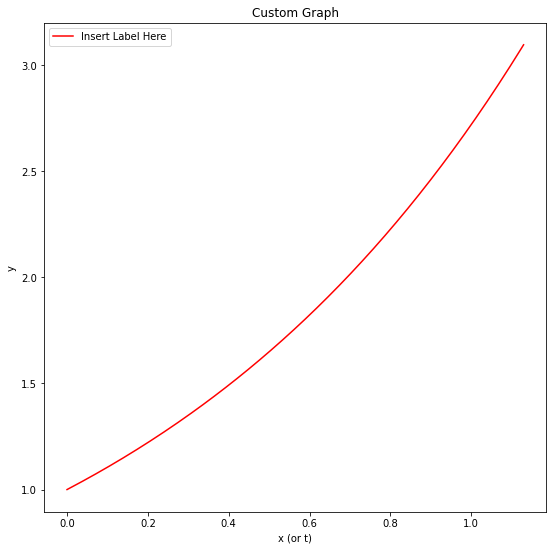

In [23]:
# Plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []

# truthList0 = []
# Uncomment or add more if validation is desired.

calculatedList0 = []
# calculatedList1 = []
# Uncomment for plotting more than one value. 

# errorList0 = []
# Uncomment for lists to store errors. 

# i = 0
# Use this i if a check has to be performed as to which row we're on. 

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oUData.txt') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        calculatedList0.append(float(row[3]))

fig, ax = plt.subplots()

# Here is where you would do any post-processing. Remember, use np.array() on the lists so operations
# can be performed properly. 

# Remember to change labels!
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title('Custom Graph')
ax.plot(positionList, calculatedList0, color='r', label="Insert Label Here") # marker='o' (or whatever symbol) can be added here. 

fig.set_size_inches(9,9)
# plt.xlim(0.0,1.0)
# plt.ylim(0.0,1.0)
# The above two lines can control the region of the graph displayed. Comment out for auto scaling. 

# ax.set_yscale("log") # Found in matplotlib's documentation. 
# Uncommenting this sets the scale to logarithmic. 
ax.legend()

Below is just a duplicate of the same graphing code but on a log scale. Since by default we have no error or truth to refer to, we can't have an automatically appearing error graph here, alas. 

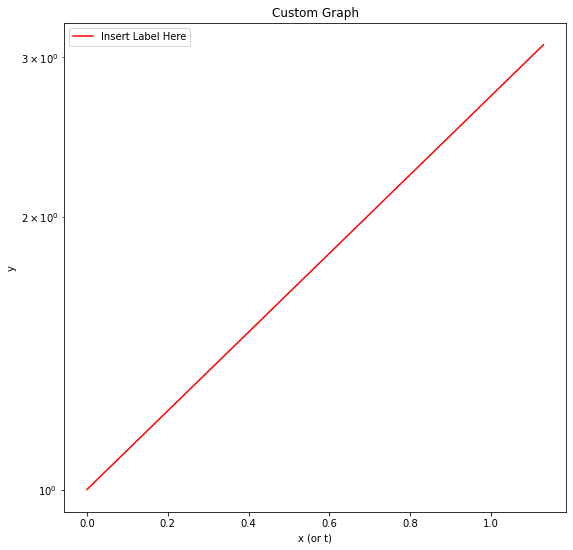

In [24]:
# Plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []

# truthList0 = []
# Uncomment or add more if validation is desired.

calculatedList0 = []
# calculatedList1 = []
# Uncomment for plotting more than one value. 

# errorList0 = []
# Uncomment for lists to store errors. 

# i = 0
# Use this i if a check has to be performed as to which row we're on. 

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oUData.txt') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        calculatedList0.append(float(row[3]))

fig, ax = plt.subplots()

# Here is where you would do any post-processing. Remember, use np.array() on the lists so operations
# can be performed properly. 

# Remember to change labels!
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title('Custom Graph')
ax.plot(positionList, calculatedList0, color='r', label="Insert Label Here") # marker='o' (or whatever symbol) can be added here. 

fig.set_size_inches(9,9)
# plt.xlim(0.0,1.0)
# plt.ylim(0.0,1.0)
# The above two lines can control the region of the graph displayed. Comment out for auto scaling. 

ax.set_yscale("log") # Found in matplotlib's documentation. 
# Uncommenting this sets the scale to logarithmic. 
ax.legend()

And that's it! It's recommended that new users try to play with the above section for a bit to see what parameters can be changed before moving on to the [Examples](NRPy+_OdieGM_Examples.ipynb) notebook. Then, after seeing some example plots and applications, to come back here and apply them. The [Examples](NRPy+_OdieGM_Examples.ipynb) notebook even has some suggested exercises that use this section!

Alternatively a user can use this section to completely house whatever project is desired, however, if it is a large project using the C code directly is recommended. 

The [Full Documentation](NRPy+_OdieGM_Full_Documentation.ipynb) notebook is always available if a user has quesitons or just wants to understand the program in greater detail. 

<a id='S4'></a>

# Step 4: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{S4}$$

((This is currently not functional due to file hierarchy, when in the actual nrpytutorial repo it should work)). 

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[NRPy+_OdieGM_Quickstart.pdf](NRPy+_OdieGM_Quickstart.pdf). (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [25]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("NRPy+_OdieGM_Quickstart")

[NbConvertApp] WARNING | pattern 'NRPy+_OdieGM_Quickstart.ipynb' matched no files
Created NRPy+_OdieGM_Quickstart.tex, and compiled LaTeX file to PDF file
    NRPy+_OdieGM_Quickstart.pdf
